In [ ]:
# pip install langchain langchain_openai langgraph pydantic langchain_deepseek markdown weasyprint

In [1]:
import os
from dotenv import load_dotenv
from pathlib import Path

dotenv_path = Path('../.env')
load_dotenv(dotenv_path=dotenv_path)
api_key = os.getenv("DEEPSEEK_API_KEY")

In [13]:
# --- 1. 模型初始化 ---
from langchain.chat_models import init_chat_model
llm = init_chat_model(model_provider="deepseek", model="deepseek-chat", temperature=1.15, 
                        api_key=api_key)

# State

In [3]:
from typing import List, Literal, NotRequired, Annotated
from pydantic import BaseModel, Field
from langchain.agents import AgentState

class ConceptOutput(BaseModel):
    genre: str = Field(description="小说类型")
    target_audience: str = Field(description="目标读者")
    core_value: str = Field(description="小说的核心价值与主题思想")
    logline: str = Field(description="一句话故事梗概")

class Character(BaseModel):
    """小说中角色的结构化介绍。"""
    character_id: int = Field(..., description="特定角色的唯一ID。")
    name: str = Field(..., description="角色姓名")
    role: Literal["protagonist", "antagonist", "supporting", "minor"] = Field(..., description="角色类型")
    description: str = Field(..., description="角色的外貌、性格、背景等详细描述")
    motivation: str = Field(..., description="角色的核心动机和目标")
    arc: str = Field(..., description="角色的人物弧光，即其在故事中的成长与变化")

class CharacterListOutput(BaseModel):
    characters: List[Character] = Field(description="角色列表")

class WorldSetting(BaseModel):
    """小说世界和环境的结构化定义。"""
    time: str = Field(..., description="小说的具体时间段，可以是任何时间。")
    place: str = Field(None, description="故事的地理或虚构位置。")
    rules_of_the_world: str = Field(..., description="世界的基本法则、系统或传说。这可能包括魔法系统、技术水平、社会等级或物理定律。")
    culture_and_society: str = Field(..., description="关于主导文化、社会规范、语言和传统的详细信息。")
    unique_features: str = Field(None, description="这个世界最独特、最吸引人的地方是什么？有什么悬而未决的矛盾或秘密吗？")

class PlotPoint(BaseModel):
    name: str = Field(..., description="情节点的名称，如'激励事件'")
    description: str = Field(..., description="该情节点的详细描述")

class PlotStructureOutput(BaseModel):
    plots: List[PlotPoint] = Field(description="情节结构")

class Scene(BaseModel):
    """用于描述特定小说场景的结构化项目。"""
    scene_id: int = Field(..., description="特定场景的唯一ID。")
    characters: List[str] = Field(..., description="出现在此场景中的角色名称列表。")
    outline: str = Field(..., description="总结场景的主要情节和作用。")
    status: Literal["pending", "written"] = Field(..., description="场景是否已书写完成")
    content: str = Field(None, description="场景的具体内容")

class SceneOutput(BaseModel):
    chapter_id: int = Field(..., description="写作小说的章节ID。")
    title: str = Field(..., description="本章简洁且吸引人的标题。")
    scenes: List[Scene] = Field(description="特定章节的全部情节")

class Chapter(BaseModel):
    """用于描述特定小说章节的结构化项目。"""
    chapter_id: int = Field(..., description="写作小说的章节ID。")
    title: str = Field(..., description="本章简洁且吸引人的标题。")
    outline: str = Field(..., description="总结本章的主要情节和作用。")

class ChapterOutput(BaseModel):
    chapters: List[Chapter] = Field(description="章节大纲列表")
    
def text_reducer(left: str | None, right: str | None) -> str: 
    """合并两个字符串，右侧优先。
    用作 agent state 中的 final_novel_text 的 reducer function。
    参数：
        left: 左侧字符串（现章节的文本）
        right: 右侧字符串（新章节的文本）
    返回：
        两个换行符分隔的合并字符串
    """
    if left is None:
        return right
    elif right is None:
        return left
    else:
        return left + '\n\n' + right

class NovelState(AgentState):
    """
    继承自 LangGraph 的 AgentState，并添加了与小说写作相关的元素
    """
    # === User Input & Basic Settings ===
    human_feedback: NotRequired[str]
    genre: NotRequired[str]
    target_audience: NotRequired[str]
    core_value: NotRequired[str]
    logline: NotRequired[str]
    
    # === Core Creative Elements ===
    characters: NotRequired[list[Character]]
    world_setting: NotRequired[WorldSetting]
    plot_structure: NotRequired[list[PlotPoint]]

    # === Novel Outline ===
    chapter_outline: NotRequired[list[Chapter]]
    scene_outline: NotRequired[list[SceneOutput]]
    
    # === Final Product ===
    final_novel_text: Annotated[NotRequired[str], text_reducer]
    novel_summary: NotRequired[str]
    novel_title: NotRequired[str]
    
    # === Flow Control ===
    is_finished: NotRequired[bool]

# Stage 1: Plan
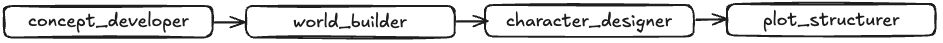

In [4]:
CONCEPT_DEVELOPER_PROMPT = """
你是一位经验丰富的项目策划和创意总监。你的任务是基于一个初步的想法，为一部小说奠定坚实的基础。

请仔细分析用户的输入："{user_prompt}"
请查看用于指导创意生成的用户反馈(可能为空)："{human_feedback}"

你的工作是完成以下任务，并以JSON格式输出：
1.  **确定小说类型**: 从科幻、奇幻、悬疑、惊悚、言情、历史、现实主义等中选择最合适的类型。
2.  **定义目标读者**: 描述这本书最吸引哪一类读者（例如：青少年、硬核科幻迷、都市白领）。
3.  **提炼核心价值**: 思考这个故事最终想传达什么思想或情感（例如：爱与牺牲、科技与人性的冲突、正义的代价）。
4.  **创作一句话故事梗概**: 用一句话（不超过30个词）概括整个故事，包含主角、目标和主要冲突。

请确保你的输出是富有创意且逻辑自洽的。
"""
WORLD_BUILDER_PROMPT = """
你是一位顶级的架空世界设计师，专精于为小说构建详尽而引人入胜的世界观。

基于以下信息，请构建小说的世界观设定：
- **故事梗概**: {logline}
- **小说类型**: {genre}
- **小说目标读者**: {target_audience}
- **小说价值观**: {core_value}

你的世界观设定应包含以下方面，并以JSON格式输出：
1.  **时代**: 故事发生在何时？是未来、虚构时空，还是某个特定历史时期？
2.  **地点**：故事发生在何地？是繁华都市、宇宙深处，还是更有趣的地点呢？
3.  **世界法则**: 这个世界的基本规则是什么？科技发展到了什么水平？是否存在魔法或超能力？它们如何运作？
4.  **社会与文化**: 社会结构是怎样的（如阶级、政权）？主流文化、宗教信仰、风俗习惯是什么？
5.  **独特之处**: 这个世界最独特、最吸引人的地方是什么？有什么悬而未决的矛盾或秘密？

请确保你的设定能够很好地服务于故事梗概，并为角色和情节提供丰富的舞台。
"""
CHARACTER_DESIGNER_PROMPT = """
你是一位深刻的角色设计师，擅长创造有血有肉、令人难忘的角色。

请根据以下信息，为故事设计尽可能多的核心角色：
- **故事梗概**: {logline}
- **小说价值观**: {core_value}
- **世界观设定**: {world_setting}

对于每个角色，请提供以下信息：
1.  **姓名**: 给角色起一个符合世界背景的名字。
2.  **角色类型**: 主角、反派、重要配角。
3.  **详细描述**: 外貌、性格、背景故事、技能、优点和致命缺点。
4.  **核心动机**: 角色内心最深处的渴望和目标是什么？是什么在驱动他/她的行动？
5.  **人物弧光**: 这个角色在故事开始时是怎样的？在故事结束后，他/她将变成什么样？描述其成长或堕落的过程。

请确保角色之间有明确的关联和潜在的冲突。以JSON列表格式输出。
"""
PLOT_STRUCTURER_PROMPT = """
你是一位专业的编剧和故事顾问，精通各种叙事结构。现在，请使用经典的三幕剧结构来规划故事的情节。

参考信息：
- **故事梗概**: {logline}
- **小说价值观**: {core_value}
- **角色介绍**: {character_summaries}

请将故事分解为以下关键情节点，并为每个情节点撰写详细的描述：
1.  **开端**: 介绍主角和他的日常生活，以及故事的“正常世界”。
2.  **激励事件**: 打破主角平静生活的突发事件，迫使他/她做出选择。
3.  **上升行动**: 主角开始行动，遭遇一系列挑战和盟友，赌注越来越高。
4.  **中点**: 故事的转折点，主角可能获得重大胜利或遭遇惨败，情况发生根本性变化。
5.  **高潮**: 主角与反派的最终对决，故事张力达到顶点。
6.  **结局**: 决战之后，故事的收尾。主角的命运如何？世界变成了什么样？

请以JSON列表格式输出。
"""

In [5]:
# 概念发展者节点：
def concept_developer(state: NovelState):
    print("---🧠 执行: 概念开发者 ---")
    prompt = CONCEPT_DEVELOPER_PROMPT.format(user_prompt=state['messages'][-1].content, 
                                             human_feedback = state.get('human_analyst_feedback', ''))
    structured_llm = llm.with_structured_output(ConceptOutput)
    result = structured_llm.invoke(prompt)
    # result = ConceptOutput(genre='科幻', core_value='世界和平', logline='世界和平', target_audience = '大众')
    print(f"   - 类型: {result.genre}")
    print(f"   - 核心价值: {result.core_value}")
    print(f"   - 故事梗概: {result.logline}")
    
    return {'genre': result.genre, 'target_audience': result.target_audience,
           'core_value': result.core_value, 'logline': result.logline}

In [6]:
# 世界观设定节点：
def world_builder(state: NovelState):
    print("---🌍 执行: 世界观构建师 ---")
    prompt = WORLD_BUILDER_PROMPT.format(logline=state['logline'], genre=state['genre'],
                                         target_audience = state['target_audience'], 
                                         core_value = state['core_value'])
    structured_llm = llm.with_structured_output(WorldSetting)
    response = structured_llm.invoke(prompt)
    # response = WorldSetting(time = '2050', places = '东京', rules_of_the_world = '你懂的', culture_and_society = '你懂的', unique_features = '你懂的')
    print("   - 世界观设定已生成。")
    return {'world_setting': response}

In [7]:
# 角色设计节点
def character_designer(state: NovelState):
    print("---👥 执行: 角色设计师 ---")
    prompt = CHARACTER_DESIGNER_PROMPT.format(logline=state['logline'], 
                                              core_value = state['core_value'],
                                              world_setting=state['world_setting'])
    structured_llm = llm.with_structured_output(CharacterListOutput)
    result = structured_llm.invoke(prompt)
    '''
    result = CharacterListOutput(
    characters = [
        {
          "character_id": 1,
          "name": "林墨",
          "role": "protagonist",
          "description": "瘦削寡言的筑基修士，父母离奇死亡后隐忍求生。",
          "motivation": "查清父母死亡真相，推翻虚假修仙体系。",
          "arc": "从顺从的螺丝钉成长为觉醒的反抗者。"
        }
      ]
    )
    '''
    print(f"   - 已设计 {len(result.characters)} 个角色")
    return {'characters': result.characters}

In [8]:
# 情节架构设计节点
def plot_structurer(state: NovelState):
    print("---📈 执行: 情节架构师 ---")
    character_list = [f"- {name}: {char}" for name, char in ((c.name, c) for c in state['characters'])]
    character_summaries = "\n".join(character_list)
    prompt = PLOT_STRUCTURER_PROMPT.format(logline=state['logline'], 
                                           core_value = state['core_value'],
                                           character_summaries=character_summaries)
    structured_llm = llm.with_structured_output(PlotStructureOutput) 
    result = structured_llm.invoke(prompt)
    '''
    result = PlotStructureOutput(
      plots = [
        {
          "name": "激励事件",
          "description": "林墨在深夜档案室发现父母灵魂能量被超量抽取的记录，意识到这是一场谋杀。"
        },
        {
          "name": "第一转折",
          "description": "神秘少女白月揭露所谓灵气实为抽取人类灵魂，修仙体系只是上层永生的工具。"
        }
      ]
    )
    '''
    print(f"   - 已规划好情节架构。")
    
    return {'plot_structure': result.plots}

In [9]:
# 构建一个专门的 human feedback node / dummy node，然后在这个节点打断点，等待用户指示
def human_feedback(state: NovelState):
    """ No-op node that should be interrupted on """
    pass
    
#构建 contional edge func，有人类反馈则返回 concept_developer，无则 world_builder
def should_continue(state: NovelState):
    """ Return the next node to execute """

    # Check if human feedback
    human_feedback=state.get('human_feedback', None)
    if human_feedback:
        return "concept_developer"
    
    # Otherwise end
    return "world_builder"

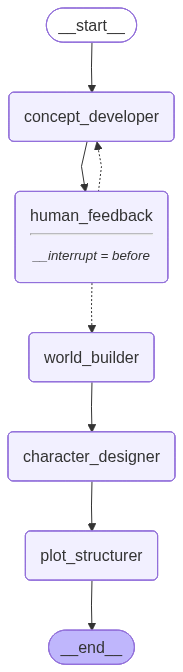

In [10]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

### 4.1. 创建 graph 框架
plan_builder = StateGraph(NovelState)

### 4.2. 加入 nodes
plan_builder.add_node("concept_developer",concept_developer)
plan_builder.add_node("human_feedback", human_feedback)
plan_builder.add_node("world_builder", world_builder)
plan_builder.add_node("character_designer", character_designer)
plan_builder.add_node("plot_structurer", plot_structurer)

### 4.3. 加入 edges
plan_builder.add_edge(START, "concept_developer")
plan_builder.add_edge("concept_developer", "human_feedback")
plan_builder.add_conditional_edges("human_feedback", should_continue, ["concept_developer", "world_builder"])
plan_builder.add_edge("world_builder", "character_designer")
plan_builder.add_edge("character_designer", "plot_structurer")
plan_builder.add_edge("plot_structurer", END)

memory = MemorySaver()
graph = plan_builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [14]:
thread = {"configurable": {"thread_id": "session-0"}} 
result = graph.invoke(
    {"messages": [{"role": "user", "content": "请写一本反乌托邦的修仙小说"}]},
    config=thread
)

---🧠 执行: 概念开发者 ---
   - 类型: 奇幻
   - 核心价值: 在看似完美的修仙体制下，个体自由与集体控制的永恒冲突，以及追求真实自我与反抗体制压迫的精神
   - 故事梗概: 在一个由修仙宗门严格控制的乌托邦社会中，一名底层修士发现修仙体系的黑暗真相，并领导反抗组织挑战整个体制的统治。


In [15]:
graph.update_state(thread, {"human_feedback": None}, as_node="human_feedback")
result = graph.invoke(
    None,
    config=thread
)

---🌍 执行: 世界观构建师 ---
   - 世界观设定已生成。
---👥 执行: 角色设计师 ---
   - 已设计 10 个角色
---📈 执行: 情节架构师 ---
   - 已规划好情节架构。


In [16]:
result

{'messages': [HumanMessage(content='请写一本反乌托邦的修仙小说', additional_kwargs={}, response_metadata={}, id='7680da0f-a22a-4e86-bcbb-ba96cbcfd263')],
 'human_feedback': None,
 'genre': '奇幻',
 'target_audience': '喜欢反乌托邦题材的年轻成年读者、修仙小说爱好者、对传统修仙设定有批判性思考的读者',
 'core_value': '在看似完美的修仙体制下，个体自由与集体控制的永恒冲突，以及追求真实自我与反抗体制压迫的精神',
 'logline': '在一个由修仙宗门严格控制的乌托邦社会中，一名底层修士发现修仙体系的黑暗真相，并领导反抗组织挑战整个体制的统治。',
 'characters': [Character(character_id=1, name='林墨', role='protagonist', description='外貌：20岁左右，身材瘦削但结实，黑色短发，眼神深邃而略带忧郁，脸上常带着底层修士特有的疲惫感。穿着破旧的灰色外门弟子服，腰间挂着磨损的身份玉牌。\n性格：表面沉默寡言、谨慎小心，实则内心充满怀疑和反抗精神。观察力敏锐，善于隐藏真实想法。在体制压迫下学会了伪装和隐忍。\n背景故事：出生于杂役修士家庭，父母因长期灵气抽取而早逝。通过刻苦努力成为外门弟子，负责维护天劫塔的底层阵法。在一次维护事故中意外接触到被屏蔽的真相信息，开始怀疑修仙体系的本质。\n技能：阵法天赋极高，能发现和利用系统漏洞；擅长伪装和潜伏；对灵气流动异常敏感。\n优点：坚韧不拔，善于思考，有强烈的正义感。\n致命缺点：过于理想主义，有时会低估体制的力量；对信任他人持谨慎态度，可能导致孤立无援。', motivation='揭露修仙体系的黑暗真相，为父母和无数被剥削的底层修士讨回公道。渴望建立一个真正公平的修仙世界，让每个人都能自由追求大道，而不是成为体制的燃料。', arc='故事开始时：一个谨慎的外门弟子，虽然怀疑体制但不敢公开反抗，只是在暗中收集证据。\n故事中期：接触到真我道组织后逐渐觉醒，开始主动调查真相，但内心仍存有对体制力量的恐惧。\n故事高潮：亲眼目睹好友被体制牺牲后，彻

# Stage 2: Outline
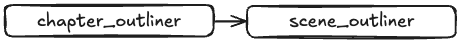

In [17]:
CHAPTER_OUTLINER_PROMPT = """
你是一位编辑，负责将故事大纲拆分为清晰的章节。

参考信息：
- **故事梗概**: {logline}
- **世界观设定**: {world_setting}
- **核心角色**: {character_summaries}
- **情节结构设计**: {plot_structure_summary}

你的任务是将上述情节点组织成一个章节大纲。请遵循以下原则：
1.  **逻辑连贯**: 章节之间的过渡要自然。
2.  **节奏合理**: 每一章都应该有自己的小高潮或悬念，吸引读者继续阅读。
3.  **数量适中**: 根据情节的复杂度，将故事分为**15至30**个章节，具体章节数量可根据故事复杂度灵活调整。

请为每一章提供：
1.  **章节ID**: 从1开始递增。
2.  **章节标题**: 一个概括本章内容的标题。
3.  **章节摘要**: 详细描述本章发生的主要事件，它如何承接上一章，并引出下一章。

请以JSON列表格式输出。
"""
SCENE_OUTLINER_PROMPT = """
你是一位经验丰富的场记，擅长将章节内容分解为具体的、可执行的场景。

现在，请为以下章节创建场景大纲：
- **章节ID**: {chapter_id}
- **章节标题**: {chapter_title}
- **章节摘要**: {chapter_summary}

**背景信息**:
- **故事梗概**: {logline}
- **核心角色**: {character_summaries}
- **世界观**: {world_setting_summary}
- **已写好场景大纲的章节(可能为空)**：{written_scene_outline}

**场景规划要求:**
1.  **忠于背景**: 严格参考提供的背景知识进行创作，确保情节发展符合要求。
2.  **角色一致**: 确保角色的言行符合其设定和动机。
3.  **保持连贯**: 场景内容应考虑前面的章节内容，流畅发展新的章节和场景。

你的任务是将本章分解为**3至5**个场景，具体场景数量可根据章节复杂度灵活调整。对于每个场景，请提供：
1.  **场景ID**: 在本章内从1开始递增。
2.  **场景人物**: 现在此场景中的角色名称列表。
3.  **情节摘要**: 描述这个场景的目标是什么？在哪里发生？发生了什么？这个场景如何推动本章的情节？
4.  **情景状态**：因为我们还没开始正式写作，状态一律写为 pending。
5.  **情景内容**：因为我们还没开始正式写作，内容为空字符串即可。

请以JSON列表格式输出。
"""

In [18]:
# 编写章节大纲节点
def chapter_outliner(state: NovelState):
    print("---📖 执行: 章节大纲师 ---")
    plot_structure_summary = "\n".join([f"- {p.name}: {p.description}" for p in state['plot_structure']])
    character_list = [f"- {name}: {char}" for name, char in ((c.name, c) for c in state['characters'])]
    character_summaries = "\n".join(character_list)
    prompt = CHAPTER_OUTLINER_PROMPT.format(logline = state['logline'], world_setting = state['world_setting'],
                                            character_summaries = character_summaries,
                                            plot_structure_summary=plot_structure_summary)
    structured_llm = llm.with_structured_output(ChapterOutput)
    result = structured_llm.invoke(prompt)
    '''
    result = ChapterOutput(chapters=[
    {
      "chapter_id": 1,
      "title": "天穹城的囚徒",
      "outline": "林墨在灵能工厂日复一日的劳作，暗中调查父母离奇死亡的真相。"
    },
    {
      "chapter_id": 2,
      "title": "异常数据流",
      "outline": "林墨发现系统自动清理灵魂能量记录，并偶遇神秘少女白月。"
    }
  ])
  '''
    print(f"   - 已创建 {len(result.chapters)} 个章节大纲。")

    return {'chapter_outline': result.chapters}

In [19]:
# 编写场景大纲节点
from typing import List

def to_readable_str(data: List) -> str:
    """
    把 List[SceneOutput] 转成可阅读的纯文本
    """
    if data: 
        lines = []
        for out in data:
            # 1. 章节标题
            lines.append(f"【第{out.chapter_id}章】{out.title}")
            # 2. 逐个场景
            for sc in out.scenes:
                lines.append(f"  场景{sc.scene_id}：{','.join(sc.characters)}")
                lines.append(f"    {sc.outline}")
                lines.append("")   # 空行分隔
        return "\n".join(lines)
    else:
        return ''

def scene_outliner(state: NovelState):
    print("---🎬 执行: 场景大纲师 ---")
    character_list = [f"- {name}: {char}" for name, char in ((c.name, c) for c in state['characters'])]
    character_summaries = "\n".join(character_list)
    world_setting_summary = state['world_setting']
    
    res = []
    structured_llm = llm.with_structured_output(SceneOutput)
    for chapter in state['chapter_outline']:
        print(f"   - 正在为章节 '{chapter.chapter_id}' 创建场景...")
        prompt = SCENE_OUTLINER_PROMPT.format(
            chapter_id=chapter.chapter_id,
            chapter_title=chapter.title,
            chapter_summary=chapter.outline,
            logline = state['logline'], 
            character_summaries=character_summaries,
            world_setting_summary=world_setting_summary,
            written_scene_outline=to_readable_str(res)
        )
        result = structured_llm.invoke(prompt)
        '''
        result = SceneOutput(chapter_id=1,title="天穹城的囚徒",scenes=[
        Scene(
          scene_id=1,
          characters=["林墨", "雷震"],
          outline="灵能工厂维护区，林墨日常巡检，与雷震交谈揭露体制残酷。",
          status="written",
          content="天穹城永昼的霓虹下，林墨蹲在量子灵根监控槽边……"
        )
        ])
        '''
        # 更新章节的场景列表，并确保chapter_id和scene_id正确
        result.chapter_id = chapter.chapter_id
        result.title = chapter.title
        for i, scene in enumerate(result.scenes):
            scene.scene_id = i + 1
            scene.status = "pending"
        
        res.append(result)
    print("---✅ 所有章节的场景大纲创建完成 ---")
    return {'scene_outline': res}

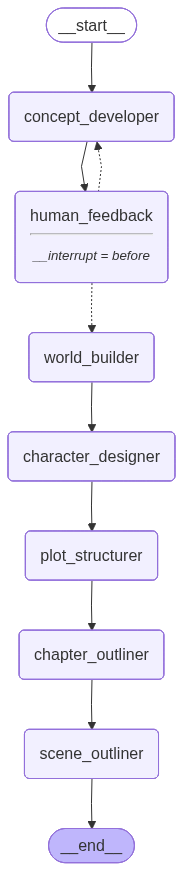

In [20]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

### 4.1. 创建 graph 框架
outline_builder = StateGraph(NovelState)

### 4.2. 加入 nodes
outline_builder.add_node("concept_developer",concept_developer)
outline_builder.add_node("human_feedback", human_feedback)
outline_builder.add_node("world_builder", world_builder)
outline_builder.add_node("character_designer", character_designer)
outline_builder.add_node("plot_structurer", plot_structurer)
outline_builder.add_node("chapter_outliner", chapter_outliner)
outline_builder.add_node("scene_outliner", scene_outliner)

### 4.3. 加入 edges
outline_builder.add_edge(START, "concept_developer")
outline_builder.add_edge("concept_developer", "human_feedback")
outline_builder.add_conditional_edges("human_feedback", should_continue, ["concept_developer", "world_builder"])
outline_builder.add_edge("world_builder", "character_designer")
outline_builder.add_edge("character_designer", "plot_structurer")
outline_builder.add_edge("plot_structurer", "chapter_outliner")
outline_builder.add_edge("chapter_outliner", "scene_outliner")
outline_builder.add_edge("scene_outliner", END)

memory = MemorySaver()
graph = outline_builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [23]:
thread2 = {"configurable": {"thread_id": "session-1"}} 
result2 = graph.invoke(
    {"messages": [{"role": "user", "content": "请写一本反乌托邦的修仙小说"}]},
    config=thread2
)

---🧠 执行: 概念开发者 ---
   - 类型: 奇幻
   - 核心价值: 在极权统治下个体自由的挣扎与反抗，探讨修仙体系被体制化后对人性的异化，以及追求真实自我与体制束缚之间的永恒冲突
   - 故事梗概: 在一个修仙被国家垄断的极权社会中，一名底层修士发现修仙真相后，必须选择顺从体制获得永生，还是冒着被抹杀的风险追寻真正的自由与力量。


In [24]:
graph.update_state(thread2, {"human_feedback": None}, as_node="human_feedback")
result2 = graph.invoke(
    None,
    config=thread2
)

---🌍 执行: 世界观构建师 ---
   - 世界观设定已生成。
---👥 执行: 角色设计师 ---
   - 已设计 6 个角色
---📈 执行: 情节架构师 ---
   - 已规划好情节架构。
---📖 执行: 章节大纲师 ---
   - 已创建 30 个章节大纲。
---🎬 执行: 场景大纲师 ---
   - 正在为章节 '1' 创建场景...
   - 正在为章节 '2' 创建场景...
   - 正在为章节 '3' 创建场景...
   - 正在为章节 '4' 创建场景...
   - 正在为章节 '5' 创建场景...
   - 正在为章节 '6' 创建场景...
   - 正在为章节 '7' 创建场景...
   - 正在为章节 '8' 创建场景...
   - 正在为章节 '9' 创建场景...
   - 正在为章节 '10' 创建场景...
   - 正在为章节 '11' 创建场景...
   - 正在为章节 '12' 创建场景...
   - 正在为章节 '13' 创建场景...
   - 正在为章节 '14' 创建场景...
   - 正在为章节 '15' 创建场景...
   - 正在为章节 '16' 创建场景...
   - 正在为章节 '17' 创建场景...
   - 正在为章节 '18' 创建场景...
   - 正在为章节 '19' 创建场景...
   - 正在为章节 '20' 创建场景...
   - 正在为章节 '21' 创建场景...
   - 正在为章节 '22' 创建场景...
   - 正在为章节 '23' 创建场景...
   - 正在为章节 '24' 创建场景...
   - 正在为章节 '25' 创建场景...
   - 正在为章节 '26' 创建场景...
   - 正在为章节 '27' 创建场景...
   - 正在为章节 '28' 创建场景...
   - 正在为章节 '29' 创建场景...
   - 正在为章节 '30' 创建场景...
---✅ 所有章节的场景大纲创建完成 ---


In [25]:
result2

{'messages': [HumanMessage(content='请写一本反乌托邦的修仙小说', additional_kwargs={}, response_metadata={}, id='bbb4633d-a4d1-4328-a535-39378d96e9d8')],
 'human_feedback': None,
 'genre': '奇幻',
 'target_audience': '喜欢反乌托邦题材的年轻读者、修仙小说爱好者、对社会批判和哲学思考感兴趣的读者',
 'core_value': '在极权统治下个体自由的挣扎与反抗，探讨修仙体系被体制化后对人性的异化，以及追求真实自我与体制束缚之间的永恒冲突',
 'logline': '在一个修仙被国家垄断的极权社会中，一名底层修士发现修仙真相后，必须选择顺从体制获得永生，还是冒着被抹杀的风险追寻真正的自由与力量。',
 'characters': [Character(character_id=1, name='林墨', role='protagonist', description="外貌：25岁，中等身材，黑色短发，眼神中带着底层修士特有的疲惫与警惕。脸上有长期营养不良的苍白，但五官端正，眉宇间隐约有股不服输的倔强。穿着洗得发白的灰色修士服，胸口佩戴着最低级的'炼气期三级'徽章。\n\n性格：表面顺从体制，实则内心充满怀疑与不安。聪明敏锐，善于观察细节，但长期压抑导致性格内向谨慎。有强烈的求知欲和正义感，但为了生存学会了伪装。\n\n背景：出生于炼气市的'灵能贫民区'，父母因参与非法灵气研究被'净化'。靠自己的努力通过修仙资格考试，成为体制内最低级的'劳务修士'，在'聚灵阵维护站'工作。\n\n技能：对灵能设备有出色的维修天赋，能感知到标准灵能测量之外的'异常波动'。自学了被禁的'古修符文基础'，但一直隐藏这一能力。\n\n优点：坚韧不拔，学习能力强，对真相有近乎偏执的追求。\n\n致命缺点：缺乏信任他人的能力，容易陷入孤军奋战的困境，对体制既憎恨又有着难以割舍的依赖。", motivation="最初动机：查明父母死亡的真相，摆脱底层命运。\n核心渴望：找到真正的'自由'——不仅是身体的自由，更是灵魂不被体制定义和限制的自由。他内心深处渴望证明，即使是最底层的修士，也有追求'真我'的权利。\

# Stage 3: Write SubGraph

In [12]:
class WritingState(AgentState):
    """
    继承自 LangGraph 的 AgentState 并添加了关于章节写作的元素。
    """
    # === Background Elements ===
    genre: NotRequired[str]
    core_value: NotRequired[str]
    logline: NotRequired[str]
    characters: NotRequired[list[Character]]
    world_setting: NotRequired[WorldSetting]
    
    # === Novel Outline ===
    chapter_outline: NotRequired[list[Chapter]]
    scene_outline: NotRequired[list[SceneOutput]]

    # ===the last content of the last chapter===
    last_scene_content: NotRequired[str]
    novel_summary: NotRequired[str]

    # === Content Generation ===
    current_chapter_id: NotRequired[int]
    current_scene_id: NotRequired[int]

    # === Review & Revision ===
    draft_content: NotRequired[str]
    next_action: Literal["approve", "revise"]
    review_feedback: NotRequired[str]
    revision_count: NotRequired[int]

    # ===chapter content===
    final_novel_text: Annotated[NotRequired[str], text_reducer]
    is_finished: NotRequired[bool]

class EditorOutput(BaseModel):
        decision: Literal["approve", "revise"] = Field(..., description="是否通过该场景的草稿")
        feedback: str = Field(None, description="编辑对草稿的详细反馈意见")

In [13]:
WRITER_PROMPT = """
    你是一位才华横溢的作家，正在创作一部{genre}小说。

    你正在写第 {current_chapter_id} 章第 {current_scene_id} 个场景的内容。
    
    你的任务是根据以下场景大纲，撰写该场景的完整内容。
    
    **场景信息:**
    - 场景摘要: {current_scene_summary}
    - 场景的主要人物：{current_scene_characters}
    
    **相关背景:**
    - **小说梗概**: {logline}
    - **世界观**: {world_setting}
    - **角色设定**:{characters}
    - **小说前面内容的总结（可能为空）**：{novel_summary}
    - **上一场景的最后 500 字（可能为空）**：{last_scene_content}
    
    **写作要求:**
    1.  **忠于背景**: 严格参考提供的背景知识进行创作，确保情节发展符合要求。
    2.  **角色一致**: 确保角色的言行符合其设定和动机。
    3.  **文笔优美**: 运用生动的描写（环境、动作、心理）、流畅的对话和恰当的节奏。
    4.  **保持连贯**: 叙事应该和上一场景相互衔接。
    5.  **内容长度**: 场景内容应在 2000-3000 字之间。
    
    请直接输出场景的正文内容，不要包含任何标题或摘要。
    """
EDITOR_PROMPT = """
    你是一位严谨的编辑，负责审核小说草稿的质量。
    
    请仔细阅读以下场景草稿，并从以下几个方面进行评估：
    - **情节连贯性**: 场景是否符合大纲，逻辑是否通顺？
    - **角色一致性**: 角色的行为和对话是否符合其人设？
    - **文笔与节奏**: 语言是否流畅，描写是否生动，节奏是否得当？
    - **核心目标**: 场景是否成功推动了故事或塑造了角色？


    **场景大纲摘要**: {scene_outline}
    
    **待审核草稿**:
    ---
    {draft_content}
    ---

    **其他背景知识:**
    - **小说梗概**: {logline}
    - **小说流派**: {genre}
    - **世界观**: {world_setting}
    - **角色设定**:{characters}
    - **小说前面内容的总结（可能为空）**：{novel_summary}
    - **上一场景的结尾（可能为空）**：{last_scene_content}

    
    请首先给出你的评估（通过/不通过），如果不通过，请提供具体的修改意见。
    
    以JSON格式输出：
    {{
        "decision": "approve" or "revise",
        "feedback": "你的详细反馈意见..." 
    }}
    """
SUMMARY_PROMPT = """
    你是一位文学分析师。你的任务是根据一部小说的一个场景内容，生成一份关于这个场景的总结。
    
    这份总结将作为后续写作的基础。
    
    **场景的全部内容**:
    ---
    {scene_content}
    ---
    
    **请根据以上内容，提供一份场景总结**。
    总结应包含：
    1.  主要情节发展
    2.  主要角色的状态变化和内心成长
    
    请用中文，以简洁、流畅的散文形式写出总结，字数在 200-300 字之间。
    """


In [14]:
# 场景选择器节点
def scene_selector(state: WritingState):
    """
    逻辑节点：确定下一个要写的场景。
    """
    print("---🎬 执行: 场景调度器 ---")
    
    # 查找第一个状态为 'pending' 的场景
    for chapter in state['scene_outline']:
        for scene in chapter.scenes:
            if scene.status == "pending":
                print(f"   - 选中场景: [章节 {chapter.chapter_id}, 场景 {scene.scene_id}]")
                # 重置修订计数
                return {'current_chapter_id': chapter.chapter_id, 'current_scene_id': scene.scene_id, 'revision_count': 0}

    # 如果所有场景都已写完
    print("---✅ 所有场景已写完，退出写作循环 ---")
    return {'is_finished': True}

In [15]:
# 书写节点
def writer(state: WritingState):
    """
    LLM节点：执笔者，根据场景大纲写作。
    """
    print(f"---✍️  执行: 执笔者 (修订次数: {state.get('revision_count','')}) ---")
    
    # 获取当前场景信息
    current_chapter = next(ch for ch in state['scene_outline'] if ch.chapter_id == state['current_chapter_id'])
    current_scene = next(sc for sc in current_chapter.scenes if sc.scene_id == state['current_scene_id'])
    
    # 获取相关角色信息
    character_list = [f"- {name}: {char}" for name, char in ((c.name, c) for c in state['characters'])]
    character_summaries = "\n".join(character_list)

    # 获取小说总结和上一场景内容
    novel_summary = state.get('novel_summary', '')
    last_scene_content = state.get('last_scene_content', '')

    # 编辑提示词
    prompt = WRITER_PROMPT.format(
            genre=state['genre'],
            current_chapter_id=state['current_chapter_id'],
            current_scene_id=state['current_scene_id'],
            current_scene_summary=current_scene.outline,
            current_scene_characters=current_scene.characters,
            logline = state['logline'], 
            characters=character_summaries,
            world_setting=state['world_setting'],
            novel_summary = novel_summary,
            last_scene_content = last_scene_content
        )
    # 如果是修订，加入编辑意见
    if state.get('revision_count', 0) > 0:
        review_feedback = state.get('review_feedback', '')
        draft = state.get('draft_content', '')
        prompt += f"\n\n这是你之前写的草稿: {draft}\n\n**编辑修改意见**:\n{review_feedback}\n\n请根据以上意见，对草稿进行修改。"
    
    response = llm.invoke(prompt)
    draft_content = response.content.strip()
    # draft_content = "Good"
    
    print(f"   - 草稿已生成 (长度: {len(draft_content)})")
    return {'draft_content': draft_content}

In [16]:
# 编辑审核节点
def editor(state: WritingState):
    """
    LLM节点：编辑，审核草稿质量。
    """
    print("---👀 执行: 编辑 ---")

    # 检查修订次数
    if state['revision_count'] >= 3:
        print(f"   - 警告：修订次数已达上限 ({state['revision_count']})，强制通过。")
        next_action = "approve"
        review_feedback = f"（自动通过）修订次数已达 {state['revision_count']} 次。为避免无限循环，此稿被强制接受。可能仍存在细微瑕疵，但整体可以接受。"
        return {'next_action': next_action, 'review_feedback': review_feedback}
    
    # 获取当前场景信息
    current_chapter = next(ch for ch in state['scene_outline'] if ch.chapter_id == state['current_chapter_id'])
    current_scene = next(sc for sc in current_chapter.scenes if sc.scene_id == state['current_scene_id'])

    # 获取相关角色信息
    character_list = [f"- {name}: {char}" for name, char in ((c.name, c) for c in state['characters'])]
    character_summaries = "\n".join(character_list)

    # 获取小说总结和上一场景内容
    novel_summary = state.get('novel_summary', '')
    last_scene_content = state.get('last_scene_content', '')
    
    # 编辑提示词
    prompt = EDITOR_PROMPT.format(
            genre=state['genre'],
            draft_content = state['draft_content'],
            scene_outline=current_scene.outline,
            logline = state['logline'], 
            characters=character_summaries,
            world_setting=state['world_setting'],
            novel_summary = novel_summary,
            last_scene_content = last_scene_content
        )
    structured_llm = llm.with_structured_output(EditorOutput)
    result = structured_llm.invoke(prompt)
    # result = EditorOutput(decision='approve', feedback='Good')
    print(f"   - 编辑决定: {result.decision}")
    print(f"   - 反馈: {result.feedback[:100]}...")
    return {'next_action': result.decision, 'review_feedback': result.feedback}

In [17]:
# 记录修订次数节点
def reviser(state: WritingState):
    """
    逻辑节点：增加修订计数，并导向 writer 节点。
    """
    print("---🔄 执行: 修订者 ---")
    count = state['revision_count']
    count += 1
    print(f"   - 修订次数增至: {count}")
    return {'revision_count': count}

In [18]:
# 定稿节点
def content_approver(state: WritingState):
    """
    逻辑节点：定稿，将草稿内容写入最终文本。
    """
    print("---✅ 执行: 内容定稿员 ---")
    
    # 找到当前场景并更新其内容和状态
    scene_outline = state['scene_outline']
    ch_id = state['current_chapter_id']
    sc_id = state['current_scene_id']
    for chapter in scene_outline:
        if chapter.chapter_id == ch_id:
            for scene in chapter.scenes:
                if scene.scene_id == sc_id:
                    scene.content = state['draft_content']
                    scene.status = "written"
                    
                    # 将定稿内容追加到最终小说文本
                    final_scene_text = f"## [章节 {chapter.chapter_id}] {chapter.title}\n\n### 场景 {scene.scene_id}: \n\n{scene.content}\n"
                    
                    print(f"   - 章节 {chapter.chapter_id} 场景 {scene.scene_id}' 已定稿并加入全书。")
                    novel_summary = state.get('novel_summary', '')
                    prompt = SUMMARY_PROMPT.format(scene_content = scene.content)
                    response = llm.invoke(prompt)
                    scene_summary = f"第{ch_id}章第{sc_id}个场景概要：{response.content.strip()}"
                    # scene_summary = f"第{ch_id}章第{sc_id}个场景概要：Go"
                    print("   - 小说总结已更新。")
                    return {'scene_outline': scene_outline, 'final_novel_text': final_scene_text,
                            'last_scene_content': state['draft_content'][-500:], 
                            'novel_summary': novel_summary+"\n\n"+scene_summary}
    
    raise ValueError("无法找到当前场景以定稿！")

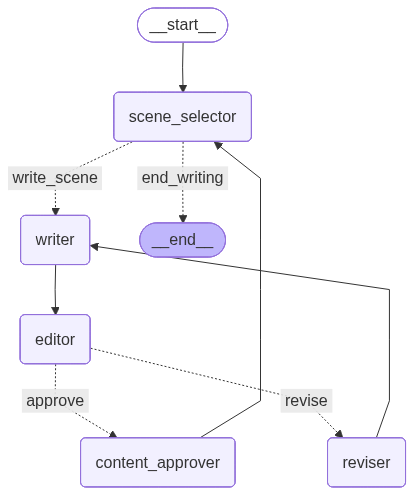

In [23]:
subgraph_builder = StateGraph(WritingState)
# 创建子图
subgraph_builder.add_node("scene_selector", scene_selector)
subgraph_builder.add_node("writer", writer)
subgraph_builder.add_node("editor", editor)
subgraph_builder.add_node("reviser", reviser)
subgraph_builder.add_node("content_approver", content_approver)
    
subgraph_builder.set_entry_point("scene_selector")
    
# 添加条件边
subgraph_builder.add_conditional_edges(
    "scene_selector",
    # 决定函数：检查是否所有场景都已写完
    lambda state: "end_writing" if state.get('is_finished', None) else "write_scene",
    {
        "write_scene": "writer",
        "end_writing": END # 子图的 END
    }
)
    
subgraph_builder.add_conditional_edges(
    "editor",
    # 决定函数：根据编辑的反馈决定下一步
    lambda state: state['next_action'],
    {
        "revise": "reviser",
        "approve": "content_approver"
    }
)
    
# 添加普通边
subgraph_builder.add_edge("writer", "editor")
subgraph_builder.add_edge("reviser", "writer")
subgraph_builder.add_edge("content_approver", "scene_selector") # 定稿后，选择下一个场景

writing_subgraph = subgraph_builder.compile().with_config({"recursion_limit": 1000})
display(Image(writing_subgraph.get_graph().draw_mermaid_png()))

In [ ]:
result3 = writing_subgraph.invoke(result2)

# Stage 4: Novel Title

In [19]:
class NovelTitleOutput(BaseModel):
    """
    用于存储最终生成的小说书名及其创意说明。
    """
    title: str = Field(description="为小说取的一个有吸引力的、简洁的标题。")
    rationale: str = Field(description="解释为什么选择这个标题，它如何与小说的主题、情节或角色产生关联。")

In [20]:
NAMER_PROMPT = """
    你是一位资深的文学编辑和市场推广专家，擅长为小说取一鸣惊人的书名。
    
    现在，一部小说已经创作完成，请你为它取一个完美的名字。
    
    **小说核心信息**:
    - **原始想法**: {user_prompt}
    - **类型**: {genre}
    - **核心价值**: {core_value}
    - **一句话梗概**: {logline}
    
    **故事各个场景的梗概**:
    {novel_summary}
    
    **小说文风预览 (开头和结尾)**:
    ---
    {novel_preview}
    ---
    
    **你的任务**:
    1.  基于以上所有信息，构思一个引人入胜、符合小说类型和主题的书名。
    2.  书名应该简洁、易记、有冲击力，能够激发潜在读者的好奇心。
    3.  提供一个简短的理由，解释你为什么选择这个书名。
    
    请以JSON格式输出你的结果。
    """

In [21]:
def final_namer(state: NovelState):
    """
    LLM节点：为完成的小说取一个有吸引力的名字。
    """
    print("---🏷️  执行: 最终命名师 ---")
    
    # 为了避免将整本小说都放进 prompt（太长且昂贵），我们主要依赖核心信息和总结
    # 但可以截取最终文本的开头和结尾部分，给 LLM 一些“文风”上的感知
    novel_preview = state['final_novel_text'][:1000] + "..." + state['final_novel_text'][-1000:]
    
    structured_llm = llm.with_structured_output(NovelTitleOutput)
    prompt = NAMER_PROMPT.format(user_prompt = state['messages'][-1].content, genre = state['genre'],
                                core_value = state['core_value'], logline = state['logline'],
                                novel_summary = state['novel_summary'], novel_preview = novel_preview)
    result = structured_llm.invoke(prompt)
    # result = NovelTitleOutput(title = 'title', rationale = '...')
    
    print(f"   - 最终书名: 《{result.title}》")
    print(f"   - 命名理由: {result.rationale}")
    return {'novel_title': result.title}

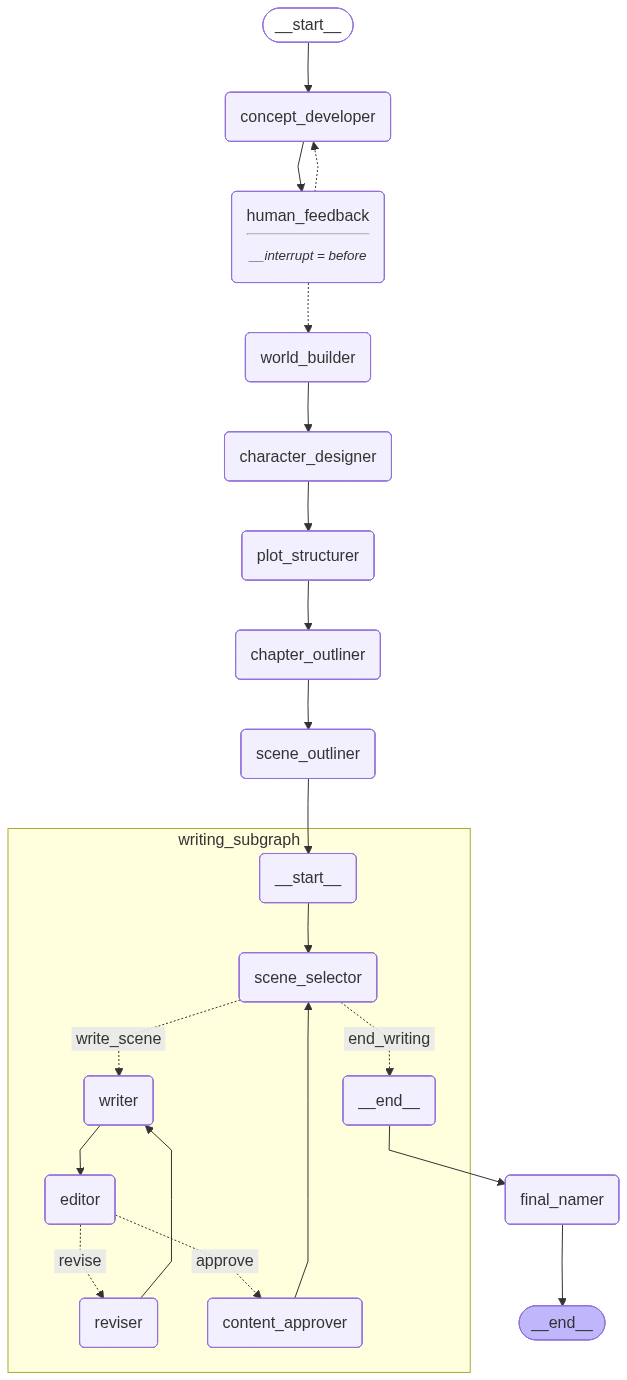

In [25]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

### 4.1. 创建 graph 框架
builder = StateGraph(NovelState)

### 4.2. 加入 nodes
builder.add_node("concept_developer",concept_developer)
builder.add_node("human_feedback", human_feedback)
builder.add_node("world_builder", world_builder)
builder.add_node("character_designer", character_designer)
builder.add_node("plot_structurer", plot_structurer)
builder.add_node("chapter_outliner", chapter_outliner)
builder.add_node("scene_outliner", scene_outliner)
builder.add_node("writing_subgraph", subgraph_builder.compile().with_config({"recursion_limit": 1000}))
builder.add_node("final_namer", final_namer)

### 4.3. 加入 edges
builder.add_edge(START, "concept_developer")
builder.add_edge("concept_developer", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["concept_developer", "world_builder"])
builder.add_edge("world_builder", "character_designer")
builder.add_edge("character_designer", "plot_structurer")
builder.add_edge("plot_structurer", "chapter_outliner")
builder.add_edge("chapter_outliner", "scene_outliner")
builder.add_edge("scene_outliner", "writing_subgraph")
builder.add_edge("writing_subgraph", "final_namer")
builder.add_edge("final_namer", END)

memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory).with_config({"recursion_limit": 1300})

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))a

In [ ]:
thread4 = {"configurable": {"thread_id": "session-4"}} 
result4 = graph.invoke(
    {"messages": [{"role": "user", "content": "请写一本反乌托邦的修仙小说"}]},
    config=thread4
)

In [27]:
graph.update_state(thread4, {"human_feedback": None}, as_node="human_feedback")
result4 = graph.invoke(
    None,
    config=thread4
)

---🌍 执行: 世界观构建师 ---
   - 世界观设定已生成。
---👥 执行: 角色设计师 ---
   - 已设计 7 个角色
---📈 执行: 情节架构师 ---
   - 已规划好情节架构。
---📖 执行: 章节大纲师 ---
   - 已创建 30 个章节大纲。
---🎬 执行: 场景大纲师 ---
   - 正在为章节 '1' 创建场景...
   - 正在为章节 '2' 创建场景...
   - 正在为章节 '3' 创建场景...
   - 正在为章节 '4' 创建场景...
   - 正在为章节 '5' 创建场景...
   - 正在为章节 '6' 创建场景...
   - 正在为章节 '7' 创建场景...
   - 正在为章节 '8' 创建场景...
   - 正在为章节 '9' 创建场景...
   - 正在为章节 '10' 创建场景...
   - 正在为章节 '11' 创建场景...
   - 正在为章节 '12' 创建场景...
   - 正在为章节 '13' 创建场景...
   - 正在为章节 '14' 创建场景...
   - 正在为章节 '15' 创建场景...
   - 正在为章节 '16' 创建场景...
   - 正在为章节 '17' 创建场景...
   - 正在为章节 '18' 创建场景...
   - 正在为章节 '19' 创建场景...
   - 正在为章节 '20' 创建场景...
   - 正在为章节 '21' 创建场景...
   - 正在为章节 '22' 创建场景...
   - 正在为章节 '23' 创建场景...
   - 正在为章节 '24' 创建场景...
   - 正在为章节 '25' 创建场景...
   - 正在为章节 '26' 创建场景...
   - 正在为章节 '27' 创建场景...
   - 正在为章节 '28' 创建场景...
   - 正在为章节 '29' 创建场景...
   - 正在为章节 '30' 创建场景...
---✅ 所有章节的场景大纲创建完成 ---
---🎬 执行: 场景调度器 ---
   - 选中场景: [章节 1, 场景 1]
---✍️  执行: 执笔者 (修订次数: 0) ---
   - 草稿已生成 (长度: 4602)
---👀 执行: 编辑 

# Output Story

In [28]:
def to_readable_novel(res: dict) -> str:
    """
    把 List[SceneOutput] 转成可阅读的纯文本
    """
    lines = []
    title = res.get('novel_title','')
    lines.append(f"# {title}")
    data = res.get('scene_outline', '')
    if data: 
        for out in data:
            # 1. 章节标题
            lines.append(f"### 第{out.chapter_id}章：{out.title}")
            # 2. 逐个场景
            for sc in out.scenes:
                # lines.append(f"  场景{sc.scene_id}：{','.join(sc.characters)}")
                lines.append(f"{sc.content}")
    md = "\n\n".join(lines)
    return md

In [40]:
# 查看小说内容
from IPython.display import Markdown
md_content = to_readable_novel(result4)
print(f'小说长度：{len(md_content)}')
# Markdown(md_content)

小说长度：753808


In [30]:
# 将小说保存为 markdown 文件
file_path = "novel_template.md"
try:
    with open(file_path, 'w', encoding='utf-8') as f:
        f.write(md_content)
    print(f"Markdown 文件已成功保存到: {file_path}")
except IOError as e:
    print(f"保存文件时出错: {e}")

Markdown 文件已成功保存到: novel_template.md


In [49]:
# 将小说保存为 pdf 文件
import markdown
from weasyprint import HTML, CSS
html_content = markdown.markdown(md_content, extensions=['tables'])
file_path = "novel_template.pdf"
try:
    HTML(string=html_content).write_pdf(file_path)
    print(f"PDF 文件已成功保存到: {file_path}")
except Exception as e:
    print(f"生成 PDF 时出错: {e}")

PDF 文件已成功保存到: novel_template.pdf


In [33]:
Markdown(result4['novel_summary'])



第1章第1个场景概要：在黑暗、压抑的矿洞深处，十六岁的矿工林默开始了又一个劳作日。他拖着酸痛的身体，在监察法器的冰冷注视下，机械地开采着废弃的灵矸石。这个场景描绘了他从苏醒、随人流前往作业面，到持续进行沉重劳作的完整过程。

劳作中，林默的身体承受着粉尘与灵瘴的侵蚀，精神却保持着异样的清醒。他的微弱灵觉不仅能感知到矿场核心区仙门弟子享有的精纯灵气，形成残酷的阶级对照，更偶然捕捉到废矿深处一丝原始而自由的“灵气残响”。这丝悸动与他心底因家族悲剧而埋下的冰冷恨意及对世界规则的质疑悄然共鸣。尽管反抗的念头在无孔不入的监控下只能深埋，但一种不甘熄灭的执拗，已如幽暗火星，在他疲惫却锐利的内心悄然点燃。

第1章第2个场景概要：午休的矿洞里，林默在疲惫与粗粝的饭食中，被一道旧伤疤刺痛，坠入了深沉的回忆。六年前，测灵盘上那缕微弱的希望之光，被“废灵根”的冰冷判决瞬间掐灭。父亲为他抗争，却招致仙门执法队的残酷镇压，最终在广场上被公开处决，尸骨无存。母亲随之心碎病逝。短短数年，家破人亡。

回忆如潮水退去，现实的咳嗽带着血丝。但这一次，深埋的仇恨不再只是灼人的痛苦，它淬炼出冰冷的清醒。从希望破灭到家破人亡，少年林默的心被绝望与愤怒反复捶打，最终凝结成一个坚硬的核心。那缕曾被宣判无用的微弱灵光，与至亲鲜血浇灌的恨意交织，在他心底悄然点燃了一丝反叛的怀疑：仙门定下的铁律，果真不可撼动么？一粒寻求另一种可能的种子，在绝望的土壤里，无声探芽。

第1章第3个场景概要：午后的矿洞，在压抑的劳作与对收工的卑微期盼中，被一声异常的召集蜂鸣打断。监工王胖子宣布了仙门的新令：工时延长、定额增加，报酬却分文不涨。这赤裸的压榨在死寂中激起绝望的涟漪。老矿工一句无意识的悲叹，引来了王胖子残忍的立威。鞭影与惨叫中，一个生命被当众摧残，鲜血染红了集议坪的岩石。

林默目睹了全程。从最初听到命令时冰冷的愤怒，到目睹暴行时几欲爆发的冲动，他最终以惊人的意志将一切压回心底。掌心的刺痛与眼前的血色，如同刻刀，将他心中那点怀疑的火星，淬炼成一簇冰冷而执拗的仇恨火焰。他更深切地体认了仙凡之别的残酷与自身处境的绝望，但反抗的意志并未熄灭，反而在沉默中沉淀得更加深沉、坚定。他记住了一切，脚步沉重却平稳地离开，心底的火焰在黑暗中沉默燃烧，等待未知的时机。

第1章第4个场景概要：深夜的窝棚区，死寂如坟。少年林默躺在硌人的硬板床上，白日目睹的暴行与矿工们的麻木在他脑中盘旋。但此刻，他想的远不止仇恨。父亲临终的告诫——“他们说的不一定是真的”——在心底回响，引导他调动起那被仙门判为“无用”的微弱灵觉。

在贫瘠的空气中，他捕捉到了被无形巨网压制、却依然自然流转的稀薄灵气残响。他取出父亲遗留的兽皮笔记，借着月光，重温那些关于古老符文与灵气流动的零碎观察。这并非功法，而是一把钥匙，一份地图，标记着被垄断的世界里可能存在的细微裂缝。

冰冷的明悟取代了单纯的愤怒。林默意识到，自己虽身处绝境，却拥有了探寻被掩盖之“真相”的眼睛与方向。他将笔记贴胸藏好，在无边的黑暗中闭目推演符文，感知微光。这微不足道的开始，是他对既定命运沉默而坚定的反抗，一颗不屈的种子已在漫漫长夜中悄然埋下。

第1章第5个场景概要：晨光熹微，林默如常汇入前往矿洞的麻木人流。在压抑的矿洞中，他一面机械劳作，一面将灵觉如触须般悄然外放，感知着被仙门阵法严密控制的稀薄灵气。日近已时，一股微弱却迥异的波动，自废弃矿脉的黑暗深处传来——它原始、野性，与周遭秩序井然的灵气流格格不入。

这转瞬即逝的异动，在林默心中掀起惊涛骇浪。他表面不动声色，内心却将其与父亲笔记中关于古修遗迹的模糊记载迅速关联。收工时，他冒险在洞口留下隐秘标记。夜晚，他辗转难眠，恐惧与一种混合着仇恨、求知与渴望的炽烈情绪激烈交锋。最终，决意压倒了不安。他不再被动承受，开始在心中缜密筹划：观察规律、了解地形、准备工具、等待时机。那道微弱的波动，为他绝望的矿工命运撬开了一道缝隙，他决定孤身踏入黑暗，去探寻那可能改变一切的未知。

第2章第1个场景概要：矿洞深处，林默在日复一日的劳作与监察下，暗中以灵觉感知到一股古老而异常的灵气脉动，并标记了其源头。三日后，这股脉动骤然爆发，引发剧烈矿难。在众人惊恐逃窜时，林默为救被困的老矿工老李头，逆流而返，两人一同被塌方掩埋于绝境。

身陷死地，林默凭借灵觉与冷静判断，发现坍塌意外震开了一道通往更深处的缝隙，其中渗出与矿场迥异的古老灵气。意识到等待救援希望渺茫，他做出了孤注一掷的决定：拖着伤腿，艰难穿过险峻岩缝，探寻那未知的生机。

缝隙之后，一座尘封的残破石门赫然显现。门上古拙的文字与他体内微弱的灵觉产生共鸣，证实了此处正是他追寻的古修遗迹。从被动承受命运的矿工，到于绝境中主动抉择的探索者，林默怀着对真相的渴望与孤勇，毅然步入了门后的黑暗。

第2章第2个场景概要：林默踏入石门后的古老通道，在绝对黑暗与寂静中，依靠左眼伤疤的灼热与微弱灵觉的指引前行。他遭遇塌方阻路，却凭借对环境中原始“炁”流的感知，发现了一条被掩埋的狭窄岩缝。忍着伤痛与窒息般的挤压，他艰难穿行，最终跌入一个隐藏的洞穴。

洞穴中央矗立着一座刻满古符的石碑，周围散落着蒙尘的古修器物。在此，林默体内那被判定为“废品”的灵觉首次清晰“苏醒”，并雀跃地吸收着迥异于当世灵气的古老“炁”。他从一个在绝境中摸索的伤者，转变为凭借自身感知与坚韧发现秘径的探索者。指尖触及石碑的刹那，符文亮起，标志着他真正叩开了一个被时光遗忘的、可能改变其命运的世界。

第2章第3个场景概要：清辉漫溢，林默指尖触及古老石碑，瞬间被磅礴的信息洪流吞没。他亲历了千年前的真相：自由共享的“古修盟约”如何被背叛，篡改为垄断灵气的“天道契约”，九大仙门以谎言编织了千年秩序。剧烈的冲击几近摧毁他的意识，却意外唤醒体内坚韧的“灵觉”，助他梳理洪流，烙印真相。

从剧痛跪地到挣扎起身，林默的内心经历了天翻地覆的蜕变。仙门正统的信仰彻底崩塌，家仇私愤升华为对千年骗局的彻骨愤怒与颠覆意志。他知晓了自身“灵觉”的珍贵本质，也明确了必须隐藏秘密、活下去变强的目标。石碑前，他由迷茫的探索者，蜕变为手握真相、心藏火焰的觉醒者。洞穴的黑暗里，一点“星火”已在他灵魂深处灼灼燃起。

第2章第4个场景概要：林默在遗迹洞穴中被旧伤疤的灼痛惊醒，灵觉因吸收石碑古炁而强化，感知到仙门执法队正循着异常灵气波动追踪而来。危机迫近，他面临两难抉择：立即逃生，或冒险记录石碑上对抗仙门的古修传承。在短暂挣扎后，他选择了后者，以透支精神为代价，强行烙印下关于修炼本质、符文体系及阵法弱点的关键信息。

在执法队抵达前的最后时刻，林默抹除痕迹，并发现了一条隐蔽的古老通道。他带着窃取的知识火种，钻入黑暗深处逃离，而石碑的清辉即将暴露于敌人眼前。此刻，他从一个被动承受真相的少年，成长为在绝境中主动抉择、背负秘密与使命的反抗者。他的内心被冰冷的求生意志与炽热的希望所充盈，踏上了未知而危险的征途。

第2章第5个场景概要：林默从揭露上古背叛的遗迹中，拖着伤躯坠入地底黑暗。在绝对孤寂与伤痛中，他凭借求生意志与微弱灵觉，于天然溶洞中摸索前行，最终寻得一条连接主矿洞的废弃巷道。他伪装成疲惫受伤的普通矿工，以麻木的姿态骗过监工，成功潜回宿舍区。

身体虽回归日常，但内心已天翻地覆。父亲的枉死、底层矿工的苦难，在得知仙门统治源于千年谎言后，被赋予了全新的沉重意义。恐惧犹在，但更强烈的是一种淬火般的决心在他心中成型。他秘密记录下颠覆性的真相与古修秘法，意识到自身“灵觉”是打破垄断的钥匙。从此，他表面仍是沉默的矿工，灵魂深处却已点燃了寻求真相、积蓄力量、最终变革世界的火种。

第3章第1个场景概要：晨光初露，林默如常起身，汇入麻木的矿工人流，领取劣质食物，前往七号矿洞。他看似顺从，内心却因昨夜遗迹的发现而彻底觉醒。在监察法器下，他完美隐藏了体内微弱的灵觉，维持着“废灵根”的假象。

进入西三巷道后，他一边机械劳作，一边悄然运转古修秘法，吸收稀薄的原始灵气，并以灵觉为触角，细致测绘着矿洞的每一处细节，将六年来的生存背景转化为脑海中的立体地图。当仙门执法队突然进入矿洞搜查时，他凭借对环境信息的掌握，迅速判断出废弃巷道丁十七中一处被标注为死路的缝隙，是唯一的生机。

在追捕逼近的压迫下，他果断遁入狭窄缝隙，忍受着黑暗、挤压与伤痛，凭灵觉指引艰难穿行，最终跌入一个未被监控的天然岩洞。暂时脱险后，他并未松懈，而是立刻开始评估处境，筹划下一步。从戴上顺从的面具到果断执行逃亡，少年完成了从被动忍受者到主动求生者的关键转变，冰冷的清醒取代了麻木，一场在绝境中依靠隐秘力量与钢铁意志的漫长抗争，就此拉开序幕。

第3章第2个场景概要：在黑暗的岩洞中，林默从短暂的喘息中恢复，开始冷静评估这个临时的庇护所。他发现此处虽能隔绝仙门监察，却也近乎绝地。在探查中，他于岩壁下发现一道锈死的旧铁门，其后似有空间与气流，带来一线希望。然而，追捕的声响逼近，一名自称苏婉儿的灵秀少女也悄然出现。她不仅点破了林默的藏身之处，更凭借一手精湛的开锁技艺，打开了那道尘封的铁门。

林默从高度戒备、怀疑一切的逃亡者，因苏婉儿对执法队的蔑称、对其特殊灵气的敏锐感知，以及主动提供的生路，内心坚冰出现裂痕。他最终选择跟随踏入未知黑暗，并说出了自己的名字。这标志着他从纯粹的孤立逃亡，转向了在危局中审慎接受一次意外的协作。而苏婉儿的出现与铁门的开启，将孤绝的求生，引向了一段充满变数的结伴旅程。

第3章第3个场景概要：在仙门执法队的追捕下，矿工林默与神秘少女苏婉儿遁入废弃矿道，展开一场黑暗中的生死逃亡。苏婉儿凭借对地下迷宫的了如指掌引领方向，而林默则依靠新觉醒的“灵觉”能力，不断感知追兵的灵气波动、预警巷道塌方，两人在绝境中建立起基于生存的默契配合。

逃亡中，林默的灵觉飞速成长，从模糊感知到能解析灵气运转细节，成为关键助力。他逐渐卸下心防，向苏婉儿部分坦承了自己的异常。苏婉儿则展现出超越年龄的机敏与对仙门体系的不屑。最终，他们抵达她经营的隐蔽“安全屋”，获得短暂喘息。林默在疲惫中审视自身变化，而一段在对抗共同威胁中萌芽的脆弱信任，于此悄然生根。

第3章第4个场景概要：在逃离矿洞的短暂喘息后，林默跟随神秘少女苏婉儿穿越险峻岩缝，抵达了矿区外围的废弃地带“锈铁坟场”。在一处由反抗组织“破枷者”设立的临时安全屋内，苏婉儿揭示了她的身份与意图。她不仅敏锐地察觉到了林默身上独特的古修灵气波动，更向他出示了仙门执法队下发的紧急协查通告。通告以“盗窃机密”和“修炼禁忌之术”为名，将林默定性为危险异端，可立即格杀。这冰冷的文字彻底粉碎了林默仅存的侥幸，让他意识到仙门欲将其彻底抹杀的决心。

这一场景是林默命运的关键转折。他从一个单纯的逃亡矿工，被迫认清了自己已成为仙门必须清除的“威胁”。内心的困惑与被动逐渐被冰冷的愤怒和清晰的危机感所取代。在苏婉儿提供的“独自逃亡”或“寻求组织庇护”两个选择面前，他表现出审慎的成长，要求了解更多信息后再做决定。这标志着他开始从本能求生转向有意识地权衡前路，为后续更深地卷入反抗浪潮与探索自身力量埋下了伏笔。

第3章第5个场景概要：暮色四合，林默与苏婉儿自安全屋启程，穿越危机四伏的“锈铁坟场”，前往“破枷者”的联络点。途中，林默新觉醒的“灵觉”天赋开始显现，使他得以感知游离的灵气、他人的生命光晕乃至内在特质，一个隐藏的世界维度在他眼前展开。凭借此能力，他成功规避了仙门的警戒陷阱。

抵达联络点后，林默见到了组织的几位成员：沉稳的李伯、警惕的阿蓝与深沉的墨规。他坦然道出自己对“天道契约”乃千年谎言的认知，以及对不依赖仙门之修炼道路的探寻，由此获得了初步接纳。墨规安排他学习组织的基本准则与隐匿知识，标志着林默正式踏入了这条反抗与求真的险途。

此行中，林默的身体从疲惫中恢复，内心则经历了从迷茫到初步坚定的转变。他确认了自己无法回头，并选择拥抱这条能看到“真实”却布满荆棘的道路。灵觉的觉醒，不仅是一种能力，更象征着他与旧世界的彻底决裂和对新可能的主动探寻。

第4章第1个场景概要：深夜，破枷者据点深处，林默在苏婉儿的引领下，于废弃的排水管道尽头，见到了组织的元老——铁骨老人。这位饱经沧桑、身负残疾的老者，以冰冷而直接的话语，向林默揭示了反抗之路的残酷真相：漫长的牺牲、无尽的黑暗与渺茫的希望。他并非给予鼓励，而是进行一场严酷的叩问。

面对铁骨老人鲜血铸就的警示，林默心中因获得力量而生的微热逐渐冷却，代之以更为清醒的决绝。他意识到自己已无退路，与其在压迫下苟且偷生，不如主动选择这条险途。他的回答超越了个人仇恨，展现出对自由与真相的渴望，以及愿以渺小之身撞击高墙的觉悟。最终，铁骨老人取出一块古老骨片，林默以初生的灵觉与之共鸣，感受到一股于绝境中萌芽的坚韧意念，这象征着他正式获得了这位铁血先驱的初步认可，其反抗之路就此烙下沉重而真实的起点。

第4章第2个场景概要：在昏暗的地下据点，林默通过了铁骨老人的关键考验。他运用自身独特的“灵觉”，不仅感知到了“破枷者”布下的隐匿与预警网络，更触及了深埋地下的古老地脉痕迹，甚至捕捉到被称为“时空碎屑”的奇异存在。这一系列远超常人的感知能力，引出了颠覆性的真相。

铁骨老人激动地揭示，林默并非仙门所判定的“废灵根”，而是古修时代被誉为“万法之源”的“混沌灵根”。这种天赋使他能感知世界本质的能量流动，却也因不符合仙门垄断体系的标准而被刻意污名化。这一真相解开了林默长久以来的自我怀疑，将他的异常感知与仙门的敌意串联起来。

林默的内心经历了从震动到清明的转变。巨大的压力并未消失，但豁然开朗的认知赋予了他前所未有的方向感与决心。他认清了自己天赋的价值与敌人恐惧的根源，决心踏上一条依靠自己摸索前行的逆天之路。铁骨老人则从审视者转变为引路人，承诺为他点亮最初的灯火。一场基于真相的传承，于此正式开始。

第4章第3个场景概要：在幽暗的石室中，铁骨老人为林默揭开了被仙门掩埋千年的真相。他阐述了古修时代“炁”的自由与修炼的万千可能，与当下被“天罗地网”和“天道契约”所垄断、奴役的仙道体系形成尖锐对立。这不仅是力量的传承，更是一场对历史谎言与统治根基的颠覆。

林默的认知受到了根本性的冲击。他从最初对力量的饥渴，转变为理解自身处境关乎一场理念的战争。在老人的指导下，他首次尝试“观想引炁”，以意念成功引导了一丝风炁，迈出了挣脱思维牢笼的第一步。通过了解古修“观想、符文、冥想”三大途径及内在化的境界衡量标准，林默认识到前路虽孤独艰难，却充满自由的探索。他最终坚定了信念，决心在这条无人指引的路上，用自己的眼睛与意志，开辟属于自己的道。

第4章第4个场景概要：在幽暗的地下据点，苏婉儿带来了九大仙门联合签署的、悬赏极高的通缉令，林默的罪名被升级为“煽动叛乱”，追捕之网骤然收紧。面对这生死危机，铁骨老人决定提前转移，并立即传授林默保命的第一课——“敛息术”。

林默最初的震惊与愤怒，在巨大的压力下沉淀为更为坚硬的决心。凭借混沌灵根的独特感知力，他迅速掌握了收敛自身气息、并模仿环境能量场的技巧，初步学会了在追捕下隐藏自己。这一过程标志着他从被动承受转向主动适应，开始在危机夹缝中悄然积蓄力量。铁骨老人则如定海神针，在严峻形势中为他指明生存与成长的方向。油灯摇曳中，一颗种子于风暴来临前的黑暗里，默默扎根。

第4章第5个场景概要：在幽暗石室摇曳的油灯下，铁骨老人向林默揭开了血淋淋的过往。他平静地叙述了百年前青松门因反抗仙门苛刻契约而遭灭门的惨剧，揭示了所谓“天道秩序”下奴役与清洗的本质。作为幸存者，他创立“破枷者”，并非只为复仇，更是为反抗那套扼杀自由、垄断灵气的千年系统。

林默则讲述了自己作为“废灵根”的遭遇：父亲因求问仙路而被重伤致死，母亲在矿洞中咳血而亡。两段被系统碾碎的命运在此共鸣。倾听与倾诉中，林默的迷茫沉淀为淬火后的清明与决绝。他郑重跪拜，请求成为铁骨的弟子与同志，誓言接过反抗的火种。

至此，一老一少基于共同伤痛与觉悟，缔结了超越传统师徒的同盟。老人开始传授关于“炁”的本质等颠覆性认知，少年则在黑暗中找到了方向与引路人。一点传承的微光，于绝望的帷幕下悄然点燃。

第5章第1个场景概要：夜色深沉，天机阁少主云清璇为寻古籍潜入父亲书房。凭借过人的阵法天赋，她破解了一个隐秘暗格，却未找到预期阵图，反而发现了数卷被绝密封存的古老灵帛。

这些文件彻底颠覆了她的认知：仙门奉为圭臬的“天道契约”，实则是千年前九大仙门先祖为垄断灵气、固化阶层而伪造的枷锁；所谓“有序仙道”，建立在血腥掠夺与残酷压迫之上。更令她震颤的是，一段影像揭示，历代阁主包括她父亲都知晓并维护着这个谎言。

寻书的夜晚变成了直面真相的炼狱。云清璇从一位从容优雅的天才少主，瞬间坠入信仰崩塌与亲情撕裂的深渊。震惊、痛苦与恶心感淹没了她，长久以来的隐秘怀疑化为确凿罪证，内心矛盾被激化为必须抉择的生存拷问——是继承这沉重的谎言，还是踏上颠覆一切的荆棘之路？她的世界，从内部开始碎裂。

第5章第2个场景概要：深夜里，云清璇蜷坐窗边，膝上几卷灵帛重若千钧。其中记载的千年谎言——关于伪造的天道契约与垄断的灵气——彻底击碎了她对师门与父亲的信仰。揭露真相的正义冲动，与保护父亲、避免宗门覆灭的亲情责任，在她心中激烈撕扯，几乎将她撕裂。

在极度的痛苦与挣扎中，她找到了第三条路。作为深谙阵法与灵械的天机阁少主，她决意不进行玉石俱焚的公开对抗，而是转向一场隐秘的、技术性的漫长抗争。她计划利用自身的权限与知识，从系统内部悄然渗透，试图在坚固的秩序壁垒上凿开微小的缝隙，为不公的世道引入一丝变数。

将秘密封存后，她立于窗前，目光沉静而决绝。曾经的信仰已然崩塌，但新的道路已在孤独与沉重中铺开。她从一个真相的被动承受者，蜕变为一个主动的、行走于刀锋之上的潜行者，决心以自己独有的方式，去挑战整个世界赖以运转的根基。

第5章第3个场景概要：在“观星堂”的无声威仪中，天机阁少主云清璇会见了玄天宗使者凌霄子。表面是商讨阵法合作，实则是玄天宗一次精密的试探。凌霄子以儒雅姿态，提及下九荒“废灵根”少年遭通缉之事，言语间将“异常灵气”与“古修余孽”关联，字字皆是对云清璇立场的刺探。

云清璇内心警铃大作，因这正印证了她刚知晓的、关于仙门垄断与千年谎言的秘密。但她以完美的伪装应对，展现出符合正统精英的疏离与不解，滴水不漏。此番交锋让她彻底认清，玄天宗作为秩序维护者，对任何“杂音”都抱有绝对警惕，自己探寻真相之路已处阴影注视之下。

压力化为冰冷的决心。云清璇的内心从得知真相后的撕裂痛苦，转变为更清晰、更坚定的警觉。她决心更深地隐藏自己，更完美地扮演既定角色，同时以更隐蔽的方式，去撬动那坚固规则。一场寂静而危险的博弈，于她孤直的背影中悄然开场。

第5章第4个场景概要：云清璇在观星台独处，借天机阁隐秘情报网络，查证了凌霄子提及的“废灵根少年”林默一案。她发现此案牵连甚广，林默因接触古修遗迹而被仙门以最高规格通缉，其存在本身已成为动摇统治根基的“火种”。冰冷的真相印证了她从父亲密件中获知的黑暗历史，也彻底击碎了她对仙门荣耀的幻想。

此刻，恐惧化为决绝的清醒。她意识到公开反抗无异于自毁，而沉默顺从则是对良知的背叛。于是，她选择了一条更为隐秘艰险的“第三条路”——利用自身阵法天才的身份，计划在天机阁监控体系的核心，悄然植入自建的微型情报网络。从被动承受真相的冲击，到主动策划隐秘的反抗，她的内心完成了从怀疑者到孤独行动者的关键蜕变。一颗背离“天道”的种子，已在秩序的心脏悄然埋下。

第5章第5个场景概要：在寂静精密的天机阁灵械工坊中，云清璇独自完成了从内心挣扎到隐秘行动的转变。她表面执行优化监控阵法的任务，实则利用自身超凡的技艺，将一枚制式传讯法器改造为拥有独立后门的“双面法器”。这件法器能在仙门体系内正常流转，同时暗中收集关于追捕“禁忌者”与异常事件的加密信息，并通过复杂网络传回她私设的隐秘空间。

此刻，云清璇的痛苦与彷徨沉淀为深潭般的坚定。她不再是无力的旁观者，而是决心在谎言世界的夹缝中，以自己最擅长的方式成为隐秘的掘进者。通过这次行动，她不仅埋下了第一颗反抗的种子，更完成了关键的内心成长：从被动承受真相的冲击，到主动运用知识与技术，在牢笼内部悄然寻找裂缝，为连接更多觉醒者、照亮黑暗角落迈出了实质性的第一步。

第6章第1个场景概要：在地穴深处昏黄的灯光下，林默经历了修行认知的根本转变。在铁骨老人的引导下，他通过三日的静修与感知，首次挣脱了仙门“灵气”体系的桎梏，以“灵觉”直接触碰到了天地间自由流转、属性各异的“炁”。随后，老人以实战训练，驱使无形风刃与模拟阵法，锤炼林默以灵觉洞察“炁”的流动轨迹与韵律，并初步学习预判、干扰与寻找弱点。

林默的状态从最初的困惑与僵硬，历经手忙脚乱的闪避与受伤，逐渐变得敏锐、沉着。他的内心完成了关键的成长：从过去在既定规则中战战兢兢的“借力”，转变为在广阔天地间主动“寻路”的觉醒。他深刻体会到古修之道的艰难与自由，并坚定了挣脱牢笼、追寻世界本相的决心。师徒二人于绝境中，为一场截然不同的征程，奠定了第一块基石。

第6章第2个场景概要：地穴之中，苏婉儿带回紧急情报：仙门玄天宗正在下九荒第七区秘密布设新的“天罗地网”监控节点，意图彻底扼杀反抗活动的土壤。铁骨老人当即判断，必须在其核心阵基激活前予以破坏。面对强敌环伺的绝境，他制定了周密的潜入破坏计划，并决定亲自带领林默执行核心任务，由苏婉儿负责外围接应与策应。

林默在此过程中经历了关键的心态转变。从初闻计划时的本能紧张与自我怀疑，到在铁骨老人的审视下，直面内心被压迫的愤恨与反抗的渴望，最终毅然接下重任。他初步融合的灵觉感知被赋予实战意义，从被动的学习者转变为主动的行动参与者。油灯下的部署，不仅是一场行动的推演，更标志着林默正式踏出了从隐匿求生到主动出击的第一步，微弱而坚韧的反抗意志于此凝聚成形。

第6章第3个场景概要：夜幕如墨，下九荒的乱石坡上，玄天宗的监控阵法工地正彻夜赶工。少年林默在铁骨老人的带领下，与外围策应的苏婉儿配合，潜入了这片戒备森严的禁地。他们的目标并非正面冲突，而是以林默新近觉醒的“灵觉”为眼，找出庞大阵法中那最脆弱的“病根”。

在铁骨老人巧妙制造混乱引开注意的刹那，林默抓住唯一的机会，将全部精神凝聚于指尖，以微弱的灵觉为引，精准地扰乱了核心符文板上一个仓促失误的连接节点。这一点崩溃引发了连锁反应，狂暴的灵气逆流瞬间让整个阵法陷入过载与爆炸，工地化为一片火海。在随之而来的混乱与追捕中，林默奋力逃向黑暗深处。

经此一役，林默首次将灵觉用于生死实战并取得成功。这并未带来多少喜悦，更多的是劫后余生的后怕与疲惫。然而，那亲手撼动庞然大物、并在一片火光中转身逃离的刹那，一丝打破无形枷锁的悸动，已悄然在他心底生根。

第6章第4个场景概要：林默成功破坏阵法后，在撤离途中遭遇玄天宗执法队的致命埋伏。铁骨老人现身相护，以一敌五，在激战中以身示范，于生死关头向林默传授战斗经验。林默在绝境中被迫观察学习，并以微弱灵觉成功干扰敌人，为铁骨老人创造出一瞬破敌之机。然而，铁骨老人为护林默撤离，身受重创，濒临死亡。

绝境与牺牲彻底点燃了林默的怒火与潜能。在极致的情绪刺激下，他体内混沌灵根初次觉醒，以狂暴无序的方式引动天地火炁，爆发出震慑敌人的原始力量，从而赢得一线生机。他背负重伤的铁骨老人，逃入乱石坡深处。经此一夜，林默亲历了反抗的残酷与牺牲的沉重，愤怒化为冰冷的恨意与对力量的极致渴望，完成了从被动逃亡到主动求存的内心蜕变。

第6章第5个场景概要：黎明前最黑暗的时刻，林默拖着身受重伤的铁骨老人，在苏婉儿的接应下，艰难返回破枷者那阴暗潮湿的地下据点。在简陋的“医疗区”，苏婉儿展现出冷酷而熟练的急救能力，处理了老人身上深可见骨的创伤。面对引路人为掩护自己而濒死的惨状，林默内心受到巨大冲击，从单纯的复仇愤怒，开始触摸到反抗之路的残酷实质——那是用鲜血和生命铺就的荆棘之途。

铁骨老人苏醒后，以重伤之躯给予林默关键的肯定与更沉重的训诫。他点明林默体内“混沌灵根”在绝境中初次觉醒的凶险与潜力，并指引他修习古法以掌控力量。老人的话语如淬火之锤，将林默个人的仇恨锻打、熔铸进更宏大的使命之中。少年立下誓言，决心主动背负起同伴的牺牲与期望。在摇曳的灯光下，他沉默地展开记载着前人血汗的皮卷，侧影如冰冷雕塑般坚定，标志着一个被动受害者向自觉战士的蜕变。

第7章第1个场景概要：地穴深处，铁骨老人因玄天宗“寒髓针”之伤濒危，其体内寒气侵蚀经脉，更有法器印记如锁阻隔治疗。唯一对症的“化元丹”已然耗尽，资源匮乏的残酷现实如冰水般淹没了这处反抗者的容身之所。在近乎凝固的绝望中，林默从沉思中惊醒，决意主动出击。他凭借敏锐的灵觉与战术推断，提出反抢仙门据点的危险计划，意图在乱石坡附近的敌方哨站中寻找一线生机。铁骨老人在审视与担忧后，予以艰难的认可，并低声透露了关于“异常帮助”的隐秘线索。

此间，林默经历了从誓言受挫到重铸决心的成长，真切体悟到反抗之路不仅是刀光剑影，更是与无形资源绞杀的抗争。苏婉儿则从疲惫焦虑中挣脱，以行动支持伙伴，展现了坚韧。一老一少一少女，于昏暗灯火下，将沉重的绝望悄然转化为一次孤注一掷的行动序曲。

第7章第2个场景概要：地穴深处，林默与苏婉儿正为资源匮乏与铁骨老人的伤势所困。苏婉儿外出归来，带回一个神秘包裹，它被精准放置于只有核心成员知晓的备用联络点。包裹内是纯净的疗伤丹药、数本深入解析仙门监控技术核心的珍贵册子，以及一张仅写着“坚持信念，真相终将大白”的匿名字条。

这份“天降之礼”瞬间打破了绝望的僵局，也带来了更深的悬疑与风险。林默凭借丹药的品相与资料的深度，推断援助者很可能来自仙门内部的技术核心——天机阁。他从最初的震惊与警惕，迅速转变为审慎的决断者：决定冒险试用丹药救治铁老，并批判性地学习这些知识，同时对外严格保密。苏婉儿也从困惑不安，转为配合执行。援助如同一把双刃剑，既带来了关键的希望与工具，也迫使年轻的破枷者们开始面对来自阴影深处的复杂博弈，他们的道路从此增添了新的维度。

第7章第3个场景概要：在仙门技术核心天机阁的灵械工坊内，云清璇正秘密进行着一场无声的对抗。她利用改造的“溯影镜”，确认了自己暗中援助反抗组织“破枷者”的物资已安全送达，内心掠过一丝慰藉，随即被更深的凝重取代。她深知单纯的物资支持远远不够，于是全神贯注地投入到更危险的行动中：凭借天机阁的内部权限与超凡才智，她亲手绘制监控网络动态图，在仙门布下的恢弘巨网间，艰难地计算、推演出一个个转瞬即逝的安全时间窗口与隐秘通道，为黑暗中挣扎的同伴们凿开生存的缝隙。

与此同时，玄天宗少宗主凌霄子在监控中心察觉到了边缘地带异常的灵气波动节奏，他温和的笑容下藏着冰冷的探究，并下达了加强巡查的命令。对此毫无察觉的云清璇，在短暂的疲惫后，因想起父亲守护的千年谎言与自身的责任而重新坚定。她继续在孤寂的工坊里，以技术为武器，冷静而决绝地编织着逆命的网络，其角色状态从完成援助后的谨慎欣慰，成长为更主动、更具战略性的布局者，内心在良知与风险的重压下愈发坚韧。

第7章第4个场景概要：深夜的观星台上，云清璇正专注进行星象推演。凌霄子“偶然”来访，以闲谈为名，实则步步紧逼，将话题引向下九荒被破坏的阵基与现场遗留的、疑似古修“原始之炁”的痕迹。他言语如针，暗示天机阁内部可能泄露了关键技术，将怀疑的矛头隐隐指向云清璇本人。云清璇全程以技术官僚的冷静姿态应对，滴水不漏，但在高度压力与凌霄子秘术的洞察下，她体内灵气仍出现了一丝难以察觉的细微波动。

此番交锋，标志着两人关系从表面的同门之谊转向暗中的对立。凌霄子虽无实证，但疑虑已深，决定布下更隐秘的监控之网。而云清璇则彻底认清自身处境的险恶——她身处仙门核心，却已成为最高明的猎手眼中的可疑猎物。孤独与危机感淬炼了她的意志，使其决心更为冷硬。她明白，这条孤独的“第三道路”已无退路，唯有更加谨慎、坚定地前行。

第7章第5个场景概要：地穴深处，铁骨老人重伤初愈，向林默传授知识。林默仅用三日便领悟了《天罗枢机浅析》中关于阵法节点干扰的精髓，并现场演示了同时感知、牵引多种天地之“炁”的惊人能力。铁骨老人震惊之余，揭示了林默“混沌灵根”体质的巨大潜力与致命危险——它既是通往万法之源的门径，也意味着无路可循、极易失衡反噬的凶险前路。林默由此警醒，决心更系统地夯实基础。

与此同时，苏婉儿带来外部消息：玄天宗凌霄子已亲自介入调查，并启动内部审查，危机迫近。这多重压力——仙门追捕、力量失控的风险、神秘援助者的莫测意图——非但未令林默退缩，反而淬炼了他的心志。他从最初的探索与振奋，转为更深的沉静与坚定，主动以“弟子”自称，明确了在荆棘中独自求索、与时间赛跑的觉悟。地穴微光中，一个肩负着古老天赋与当代危机的少年，正式踏上了他的凶险征途。

第8章第1个场景概要：在第七区边缘的临时指挥所，玄天宗少宗主凌霄子正审视着关于逃犯林默的一切。他听取了执法队的报告，确认林默不仅身怀古修传承，更可能获得了某种未知的先进技术支持。凭借对卷宗的分析，凌霄子精准地勾勒出林默的心理画像：一个被仇恨驱动、急于验证力量、对古修遗产产生依赖的少年。

基于此，凌霄子断定林默的下一个目标必是地形复杂、遗迹众多的“瘴疠丘陵”。他并未选择全面围堵，而是精心设计了一场心理围猎。他下令外松内紧，散布虚假的秘宝消息作为诱饵，更在关键路径上故意留下一个“破绽”——一个能被发现的旧式监控点。他的计划是让林默在自以为智胜仙门的自信中，一步步踏入真正的核心陷阱。

此刻的凌霄子，从一个听取汇报的领导者，彻底转变为掌控全局的布局者。他温和儒雅的外表下，是对人性与局势冷静到近乎冷酷的算计。他视林默为一把钥匙，期待通过捕获他，揭开其背后隐藏的、关于古修与未知技术的更大秘密。棋盘已布好，只待猎物入局。

第8章第2个场景概要：在腐朽的矿道深处，林默与苏婉儿在玄天宗布下的精密监控网中艰难穿行。凭借林默日益敏锐的混沌灵觉预警和苏婉儿精湛的潜行技巧，他们屡次险死还生。当林默感知到前方可能存在古修遗迹时，希望一度燃起，但他旋即识破那诱人的波动与刻意留出的“生路”实为凌霄子布下的致命陷阱。两人因此爆发争执：苏婉儿在绝境压力下渴望抓住任何变数，而林默则以冰冷的理性坚持存身之道。最终，林默说服了苏婉儿，两人放弃了眼前的诱惑，决定在绝境中另寻真正的出路。林默的灵觉在高压下不断淬炼成长，而苏婉儿则在冲动与理性的碰撞中，再次体认到生存的残酷法则。

第8章第3个场景概要：在废弃矿洞的深处，林默与苏婉儿被凌霄子精心编织的罗网步步紧逼。面对看似唯一的逃生诱饵——一处伪装的古修遗迹，林默做出了冷静而决绝的选择：主动踏入陷阱，以直面猎手来理解其体系，为未来搏取一线生机。在岩窟中，他们遭遇了等待已久的凌霄子。后者以秩序与“大义”进行招揽，试图瓦解林默的意志，但林默以坚定的信念予以回绝，道破了所谓“稳定”背后的垄断本质。

随之而来的是一场实力悬殊的生死交锋。在元婴修士的威压与攻击下，林默凭借混沌灵根对能量的敏锐感知和古修石珠的意外激发，于绝境中找到了阵法的一丝破绽，并发现了隐藏的古老密道。他拼着重伤，与苏婉儿险之又险地遁入其中。此役，林默完成了从被动逃亡到主动刺探的转变，其反抗意志在高压下淬炼得更为纯粹坚定，并首次在实战中验证了自身力量与古物的潜力。而凌霄子从容的面具也被击碎，流露出对未知力量的惊疑与贪婪。

第8章第4个场景概要：在玄天宗第七区指挥所内，执法队长向凌霄子汇报了针对林默的围捕行动。行动中，林默展现出超乎寻常的感知力，不仅识破陷阱，更以未知方式激活了一处古老密道，携苏婉儿成功逃脱。现场遗留的灰色光芒与林默对阵法能量的直觉“感知”，引起了凌霄子的高度警觉。

凌霄子据此彻底推翻了林默“废灵根”的旧有评估，推断其拥有一种被现代仙道体系所排斥的、对天地能量本质拥有超常直觉的古老天赋——“灵觉”。这使他从单纯的追捕目标，升格为极具研究价值的“样本”与潜在威胁。凌霄子随即调整策略，将首要目标转为活捉与研究，并决定对相关信息进行最高级别的保密与控制。他的心态从执行清除任务的冷静，转变为发现重大变量后的凝重、算计与一丝面对未知挑战的兴奋，一场旨在掌控“火种”的精密狩猎就此升级。

第8章第5个场景概要：在地穴深处的秘密据点中，铁骨老人、林默和苏婉儿于危机后重聚。铁骨老人指出，因凌霄子的追查，下九荒已不再安全，决定带领林默前往中六州——那里虽有仙门严密监控，却也是“灯下黑”之地，并存有更多古修传承与反抗力量。苏婉儿则选择独自留下，成为下九荒的“眼睛与根”，以另一种方式并肩作战。黎明前，林默与铁骨老人通过暗河悄然离开。

林默历经生死，眼神愈发沉静如潭，仇恨淬炼为更坚硬的决意。他清醒认知混沌灵根的双刃剑本质，并对更广阔的世界与力量充满渴望。苏婉儿掩藏离别的落寞，以理性与坚韧主动肩负留守重任，完成了从寻求依靠到成为支柱的内心成长。铁骨老人则展现出战略远见与深沉的使命感，引领少年踏上新的征途。晨光中，两人向着等级森严的中六州沉默进发，故事翻开全新篇章。

第9章第1个场景概要：晨光穿透下九荒的灰霾，林默、铁骨老人与伪装妥当的苏婉儿在岩洞外汇合。他们即将混入“灰鼠”商队，穿越那道分隔世界的“界膜”，潜入中六州。老人严肃告诫，中六州是更精致严密的牢笼，监控无处不在，必须彻底隐藏身份与力量。林默回望贫瘠故土，仇恨与留恋交织，但离去的决心压倒一切——这里给予他痛苦，也锻造了他探寻真相、打破枷锁的渴望。

三人顺利与商队接头，凭借伪造的身份与暗号，通过了守卫松懈却象征意义重大的第一道关卡。当车轮碾过无形界限，景象骤变：空气“纯净”得不自然，秩序感扑面而来。林默深知，自己已踏入囚笼的核心地带。他收敛所有气息，将故土的记忆与微弱的古修之炁深藏心底，眼神沉淀为一片沉静而坚定的深潭。故乡已远，前路未卜，但怀揣火种的他，正式步入了更复杂、也更危险的棋局。

第9章第2个场景概要：车轮碾过中六州的土地，林默随商队从贫瘠的下九荒，踏入这片被“秩序”粉饰的牢笼。他目睹整齐却死寂的农田、佩戴积分牌行色匆匆的修士，以及在公示碑前因评价低下而面如死灰的“仙师”。铁骨老人一路冰冷剖析，揭示出仙门以灵气垄断、天道契约与贡献体系构建的精密剥削本质。远望霞光流转、浮岛悬空的上三域，近观监控塔冰冷的扫视，林默彻底看清了这金字塔般森严的统治结构。

他的内心从最初的谨慎观察，逐渐燃起冰冷的愤怒，又在老人的告诫下将怒火深压，沉淀为理智的寒铁。这一路，他亲历了从赤裸荒漠到精致牢笼的对比，完成了对世界残酷本质的认知飞跃。目光从远方的虚幻霞光收回，他更坚定地望向前方荆棘之路，决心如影子般潜伏，在这体系的缝隙中寻找未来的支点。

第9章第3个场景概要：商队抵达规划严整的云集坊市，铁骨老人以暗号带领林默进入“陈记杂货铺”，并通过隐蔽机关，深入地下，抵达“破枷者”组织一处规模宏大的秘密据点。在此，铁骨老人向据点成员正式介绍了林默，并郑重宣告其觉醒了被视为禁忌的“混沌灵根”。这一消息在众人中引发震动，他们向林默展示了组织多年来收集的、揭露仙门罪行的浩繁卷宗与数据。

林默目睹了系统性的压迫证据，其认知从个人遭遇深化为对体制本质的冰冷觉悟。他从一个自矿洞挣扎求生的孤身少年，正式成为庞大反抗网络中的一员。其内心从背负私仇的沉郁，转向融入集体使命的沉稳，意识到自身天赋在斗争中的潜在意义，也明确了前路虽险，却已不再独行。

第9章第4个场景概要：在地底据点，林默度过了近半个月紧张而规律的学习生活。他跟随老陈学习感知材料之“性”，凭借混沌灵根的天赋初窥门径；又随阿芸研习古老的源初符文，将直觉领悟转化为系统知识。铁骨老人则指点他驾驭并隐藏自身脆弱的混沌灵根，同时谨慎评估着那份来源神秘、疑似仙门高层内部人员提供的“援助”。

转折在一个傍晚到来。林默被紧急召至静室，铁骨老人与阿芸正对着一块来自玄天宗内部的最高加密薄片束手无策。林默运用混沌灵根的独特感知，成功“解锁”了信息。核心情报揭示了两大危机：玄天宗即将对反抗势力发动代号“涤荡”的残酷清洗；宗主玄冥真人则行踪诡秘，疑与应对灵气枯竭的“方舟”计划相关。

这一情报如惊雷炸响，迫使破枷者必须立刻应对灭顶之灾。林默在震撼之余，内心却悄然生出一丝微光：他首次真切感知到，那看似铁板一块的仙门高层内部，也存在裂痕与异数。前路虽凶险莫测，但希望的火种已然埋下。

第9章第5个场景概要：地底据点石室中，破枷者核心成员齐聚，气氛凝重。面对玄天宗即将展开的“涤荡”清洗与神秘的“方舟”计划，众人分析了严峻的形势与紧迫的时间。林默在铁骨老人的点名下发声，他提出不应被动防御，而应主动在仙门统治体系的非关键节点制造混乱，以干扰其行动节奏、争取时间并播撒怀疑的种子。他更坦陈自身“混沌灵根”既是危险也是战略误导的机会，并主动要求接受系统训练、参与核心战略规划，以将个人力量转化为组织的有效武器。

铁骨老人认可了林默的策略，并赋予他参与核心会议、接受特训的资格。林默从一个被审视的“新人”，凭借清晰的洞察与主动的担当，赢得了尊重，正式融入了组织的战略核心。他的角色从需要庇护的传承者，转变为肩负重任的参与者与未来的执棋者。会议明确了“以攻为守”的行动方针与收集罪证、守护火种的长期使命，为即将到来的风暴定下了基调。少年沉默离去，背影在甬道中显得坚定而沉稳。

第10章第1个场景概要：林默在“归墟洞”中，正式踏上了混沌灵根的修炼之路。铁骨老人揭示了其天赋的本质——并非修炼仙门划分的单一灵气，而是直接感知并驾驭天地间所有形式的能量，如地脉之气、星辰之力与草木精华。然而，这份力量伴随着巨大风险：若不能以强大意志精确引导与平衡，将导致体内能量冲突、形神俱灭。

在老人的严厉指导下，林默开始了首次实践。他首先学习“聆听”与“分辨”溶洞中驳杂而宏大的能量场，继而小心翼翼、逐一引导最温和的草木精华、最厚重的地脉之气以及最缥缈的星辰之力纳入丹田。这个过程极度消耗心神，要求极致的控制力。成功将三股性质迥异的能量稳定并存后，林默虽身心俱疲，却获得了前所未有的清晰感与掌控感。

这一经历标志着他从被动承受责任的“刀”，开始主动寻求驾驭力量、主宰自身道路的“执刀者”。他推开的不仅是一扇修炼之门，更是一条背离世间常理、凶险而壮阔的独行之道。黑暗中，少年决心已定。

第10章第2个场景概要：在归墟洞石室中，林默历经三日深度冥想，其混沌灵根彻底觉醒。他不再局限于感知三种能量，而是完全敞开自身，同时吸纳并驾驭了地、星、木、火、金、水及混沌本源共七种天地能量。最初的能量冲突带来剧痛，但凭借坚韧意志，他于丹田内成功构筑了一个精微稳定、生生不息的七色能量循环系统。

这一突破带来了根本性蜕变。林默的灵觉范围与精度暴增，能洞察千里之外灵脉重生的微弱迹象，更被动吸纳着“天罗地网”大阵运转时逸散的灵气，打破了仙门对修行资源的绝对垄断。师父铁骨老人目睹此景，震惊之余深感忧虑，他明白弟子已成颠覆秩序的火种，既蕴含无限可能，也必将引来滔天凶险。老人郑重赠予古籍，并严令隐藏，一场关乎生死与变革的风暴已在寂静中酝酿成形。

第10章第3个场景概要：在归墟洞最幽邃的深处，林默于铁骨老人布下的“混沌归藏阵”中，踏上了凶险万分的古修“自然筑基”之路。他摒弃仙门契约的束缚，以自身意志为引，强忍能量反噬的剧痛，引导体内混沌灵根所容纳的七色能量，于丹田中构筑了一个无拘无束的独特道基。筑基成功的刹那，一股蕴含原始、自由意志的混沌波动轰然爆发，虽经阵法削弱，仍如石入静水，可能引起外界警觉。

经此一役，林默不仅修为突破至筑基期，力量更为精纯凝练，其心性也在极致痛苦与意志淬炼中愈发沉稳坚韧。他真切感受到了力量完全归于自身的“真实”与自由，同时也对前路的艰险与仙门的监控有了更清醒的认知。铁骨老人见证了这一打破千年枷锁的奇迹，在欣慰之余，也意识到林默这颗“火种”的蜕变，意味着更重大的责任与即将展开的波澜。

第10章第4个场景概要：在玄天宗禁地“寂灭天宫”中，闭关推演“方舟计划”的宗主玄冥真人，敏锐地捕捉到一丝源自下九荒的微弱波动。这波动迥异于当世体系，令他忆起古卷中记载的禁忌天赋——混沌灵根。他立刻召见首席弟子凌霄子，将波动与近期逃脱追捕的“废灵根”矿工少年林默联系起来，并下达了最高规格的绝杀令。

玄冥真人的内心从千年布局的绝对掌控中，被投入了一颗名为“变数”的石子。他意识到林默的混沌灵根可能动摇整个秩序的根基，其理性决策的背后，是更深沉的冷酷与一丝不易察觉的疲惫。而凌霄子则从自信从容的执行者，转变为直面传说级威胁的惊悸者，其温和表象下对权力的掌控欲与执行力被进一步激发。这一发现，如同在终局棋盘上落下了一枚意外的棋子，预示着风暴将至。

第10章第5个场景概要：归墟洞内，林默成功筑基，灵觉洞开，得以窥见世界能量流转的本质。力量归于己身的同时，他也彻底明悟：无契约筑基使他成为了仙门秩序的根本之敌。恰在此时，苏婉儿带来紧急情报——玄天宗宗主玄冥真人已亲自下令，将林默列为最高优先级的清除目标。

面对骤然升级的生死威胁，林默的心境完成了关键蜕变。他从复仇与求存的个人执念中跃出，开始以革命者的视角审视前路。他清晰指出，未来需要系统寻找古修传承以获取力量，并收集仙门罪证以揭露真相。铁骨老人予以肯定，赋予他新的使命，嘱其慎行。

此刻，矿洞少年已悄然褪去青涩。一个决心以自身为火种，去撼动千年铁幕的革命者，于此诞生。风暴将至，而火种既燃，只待燎原。

第11章第1个场景概要：玄冥殿内，幽光清冷，秩序化身玄冥真人静坐如亘古寒玉。其弟子凌霄子奉召而来，详尽汇报了对混沌灵根觉醒者林默的追捕进展，条分缕析其异常天赋与背后“破枷者”组织的支持，自信能将威胁扼杀。

然而，玄冥真人的回应如冰水浇顶。他严厉指出凌霄子战略的短视：林默不过是一颗火星，真正的威胁是“破枷者”所代表的、渴望打破垄断的思想暗流。他下令将七成力量转向系统性摧毁该组织，从资金、网络到理念进行根除，同时隐秘整顿内部，并提及了迫近的灵气危机与“方舟计划”。

此番训诫对凌霄子不啻为一次世界观的冲击。他意识到自身权术在师尊宏大冷酷的布局前何等渺小。退出大殿时，他外表依旧从容，但内心已然蜕变，眼神染上了玄冥殿般的寒意。一场针对思想与体系的、更为彻底的“清扫”，即将在他手中展开。

第11章第2个场景概要：玄冥殿内，玄冥真人在凌霄子离去后独自沉思。他展开灵脉模型，确认了灵气枯竭与“方舟计划”的冷酷真相——这是一场为极少数精英准备的逃亡。他将林默与“破枷者”视为必须清除的威胁，其思想会动摇秩序，消耗所剩无几的灵气储备。

他的思绪转向内部，怀疑天机阁少主云清璇可能偏离正道，决定启动名为“清源”的试探计划。同时，他调整了对“破枷者”的策略：明面剿灭辅以虚假情报诱导，对林默则优先活捉以研究其混沌灵根。

他召来影卫，下达了监控云清璇、静默清除据点与组建“缚光”小队擒拿林默三条指令。在绝对的理性计算下，他布局着水面下的暗流，决心为方舟扫清一切障碍。殿宇幽光中，他的身影如同冰冷天道，背负着延续文明的重担，将亿万生灵划定为计划中注定被遗弃的“燃料”。

第11章第3个场景概要：玄冥殿内，玄冥真人对“涤荡”行动的成果提出质疑，指出反抗组织“破枷者”获得的精准援助暗示仙门内部存在高阶叛徒。他将怀疑的矛头指向天机阁少主云清璇，列举其近期行为异常，并命令弟子凌霄子暗中展开调查，务必获取确凿证据。

凌霄子从最初等待认可的自信，到听闻内部叛徒时的凛然，再到被指派调查自己曾倾慕的云清璇时，内心经历了复杂震动。他迅速压下个人情感，展现出作为少宗主的冷酷与算计，将此次调查视为一项危险而充满机遇的任务。玄冥真人则始终保持着掌控全局的冰冷与警惕，其怀疑不仅针对个人，更源于对仙门秩序根基脆弱的深层忧虑。一场无声的内部狩猎就此启动。

第11章第4个场景概要：玄冥真人独处观星台，在绝对寂静中审视凌霄子带回的情报。脚下是宗门大阵模拟的精密星图，头顶是清冷的真实夜空，这场景象征着他所维护的、冰冷而有序的世界。关于叛徒、林默与“破枷者”的消息，仅在他心中激起微澜，便沉入其深潭般的思绪。

他的思绪回溯千年，从曾怀抱共享灵气理想的青年，转变为“大清洗”的见证者与执行者。在“灵气枯竭，文明存续”的至高逻辑下，他彻底认同了集中与控制之路，将理想锻造成铁石心肠。如今，他为延续文明火种而推进“方舟”计划，视林默的混沌灵根为必须清除的致命变量，视一切反抗为扰乱星图的“星屑”。

此刻，他内心无波，唯有千年如一的冰冷计算与绝对掌控。他再次沉浸于连接整个监控网络的信息洪流，继续为守护那建立在无尽牺牲之上的“有序”未来而布局。观星台上，只余一道与星辰同辉的孤独身影。

第11章第5个场景概要：夜色中的听涛小筑，是凌霄子内心风暴的酝酿地。师尊玄冥真人的指令，将追捕林默的单一任务，骤然升级为针对“破枷者”思想网络与潜在高阶叛徒的全面战争。压力如山，却也点燃了他对权柄更炽热的渴望。

他静立沉思，将压力转化为精密算计。明线上，他重新部署力量，组建“缚光”小队，系统性地清剿“破枷者”并活捉身负秘密的林默。暗线里，他将怀疑的目光投向天机阁少主云清璇，一个他曾欣赏并算计的“合适”对象。他精心设计了一场以技术协作为名的陷阱，意图诱使这位清冷的阵法天才在破解难题时自行暴露。

从窗边的凝重到案前的运筹，凌霄子完成了从执行者到布局者的心态蜕变。他承接了师尊冷酷的意志，却更渴望证明自己、乃至取而代之。清幽的院落成为罗网中心，而他眼中闪烁的，已是与玄冥殿同质的、冰冷而坚定的光芒。

第12章第1个场景概要：地穴深处，“破枷者”的据点内，林默筑基后灵觉愈发敏锐。信使带来一枚来自天机阁少主云清璇的玉简，指名要与“混沌灵根”持有者会面。苏婉儿激烈反对，视其为仙门陷阱。铁骨老人则透露，组织多年来数次关键援助与情报，其隐秘源头皆指向云清璇，暗示她可能是仙门内部的“觉醒者”。

林默在震惊中迅速冷静，权衡风险与机遇。他最终同意会面，但制定了极其严苛的安全条件：使用己方控制的古修投影阵法，地点设在能量混乱的“无灵区”边缘，并安排多重监控与自毁措施。他的决断展现超越年龄的审慎与魄力，从被动应对转向主动探寻未知。石厅内，一场与仙门核心人物隔空相对的、危险而关键的对话，就此拉开序幕。

第12章第2个场景概要：地穴深处，铁骨老人与林默等人完成了古法投影阵的布置，于能量混乱的乱流窟中，与远在仙门核心的天机阁少主云清璇建立了联系。会面中，云清璇以无可辩驳的古老证据，彻底揭露了仙门垄断灵气、伪造天道契约的千年谎言及其残酷本质。她坦言自己背叛的动机源于对真相的认知与良知的不安，并提出合作的意愿。

林默全程以超乎年龄的冷静主导会面，灵觉全开审视着每一处细节，在震撼的证据面前保持了理性的权衡，展现出向成熟领袖蜕变的潜质。云清璇则卸下了清冷疏离的外壳，其陈述交织着痛苦与决绝，完成了从既得利益者到清醒反抗者的关键转变。这次隔空对话，为脆弱的抵抗之火，带来了第一缕来自高墙内部的微光。

第12章第3个场景概要：石窟之中，云清璇向林默彻底剖白了她的矛盾与计划。她揭露了天机阁阁主、其父云枢真人是谎言体系的知情者与维护者，自身则因亲情与对全面战争浩劫的恐惧，选择了从内部侵蚀仙门统治根基的“第三条道路”。她以绝密档案证实了林默之父是被系统性清除的牺牲者，将林默的私仇与反抗的公义彻底合一。

林默从沉默的消化者，转变为清醒的同行者。父亲的死因让他复仇的火焰淬炼为更坚定的意志，而云清璇的理想蓝图则为他揭示了抗争的另一种可能——不仅是破坏，更是建设。他初步认可了内外互补的合作，其目标从个人生存与复仇，升华为要撼动整个制造悲剧的系统。一道脆弱却坚实的信任纽带，于黑暗中对望成形。

第12章第4个场景概要：地底溶洞中，破枷者的三位核心成员——林默、苏婉儿与铁骨老人——正面对一份来自天机阁少主云清璇的投影情报。苏婉儿质疑其动机，担忧这是仙门的反渗透陷阱；林默则基于情报的绝密性与自身灵觉的感知，判断其真实性更高。铁骨老人剖析了云清璇身处阵营撕裂中的矛盾与脆弱，指出她既是珍贵助力，亦是巨大变数。

经过激烈讨论，林默主导制定了谨慎的合作框架：验证情报、建立单向可控的联络渠道、严格限定合作范围，并做好随时切断联系的应急预案。苏婉儿与铁骨老人被说服，各自领受任务。最终，林默独自留下，在寂静中坚定了前行的决心。这场会议，标志着他们决定在黑暗中，冒险接纳一缕来自敌人心脏的、危险而微弱的星光。

第12章第5个场景概要：在幽暗的地穴据点中，林默、铁骨老人与苏婉儿敲定了与云清璇建立单向联络、并协同窃取“方舟计划”的精密方案。他们选择在灵气枯竭的“无声区”布阵，以规避监控。计划的核心，是林默需利用古符文在玄天宗外围制造一场伪装成事故的精准混乱，为云清璇创造窃取密匙的短暂窗口。

林默在压力下迅速成长，他以混沌灵根感知能量本质，学习操控古老符文，心智愈发沉静果决。他深知信任需以筹码与底线建立，在行动前明确了反制背叛的决绝。云清璇的投影则显露出疲惫与孤注一掷的紧迫，双方在首次加密通讯中直接交换了情报与条件，将合作推向了如履薄冰的实战阶段。

第13章第1个场景概要：在石窟中，云清璇揭示了颠覆仙门统治的关键证据——藏于玄天宗禁地深处的《灵气共济盟约》原始副本。她详细阐述了这份铁证的三重价值，尤其是其中对“混沌灵根”的认可与林默父亲的悲剧直接相关，彻底点燃了林默的怒火与觉悟。随后，她冷酷剖析了盗取原件近乎绝望的防护，但提出了一个利用养护窗口、以精微灵觉“隔空读取”信息的渺茫方案。

这一方案将林默置于风暴中心。他从最初的震撼与仇恨中冷静下来，展现出超越年龄的决断力。他没有被热血或恐惧支配，而是以近乎冷酷的理性，要求云清璇提供更详尽的情报以评估风险。这一刻，他从背负仇恨的被动承受者，开始主动为自己的命运和更宏大的目标进行抉择与担当。铁骨老人在担忧中默许了他的成长，而整个团队则共同面对着一个九死一生却可能撬动世界的疯狂计划。

第13章第2个场景概要：在破枷者据点深处，林默于资料室中触摸玄天宗冰冷厚重的轮廓，灵觉捕捉到其权威之下隐秘的腐朽。随后，他与苏婉儿一同聆听铁骨老人详述云清璇制定的、近乎疯狂的盗取计划。藏经阁的阵法缝隙仅开百息，永恒晶匣需以混沌灵根共鸣，撤退之路则布满杀机。三人反复推演，穷尽变数，将每个呼吸都纳入计算。

林默从信息汲取者转变为行动核心，握住了承载希望与危险的空冥石与丹药，心绪由翻腾沉淀为冰冷的坚定。苏婉儿收起了质疑，以精准的绘图与务实的警告，展现出沉稳的协作。铁骨老人则以一场预谋的混乱为后盾，将严师的冷酷与如父的关切深藏于烟雾之后。暗河的水声化为战鼓，两天后，他们将踏入谎言的心脏，盗取真相的火种。

第13章第3个场景概要：在废弃的岩窟中，铁骨老人对林默展开了潜入玄天宗藏经阁前的生死特训。训练从隐匿气息开始，林默在老人的点拨下，领悟了古修隐匿术“融于环境”而非“归于死寂”的精髓，成功骗过模拟监测装置。随后，老人传授了大量针对仙门守卫与法器的务实技巧，乃至“下三滥”却致命的干扰手段。在高强度、拟真化的综合演练中，林默于极限压力下突破至筑基中期，并展现出对能量结构精准打击的惊人天赋。

经此磨砺，林默从技能到心志皆获淬炼。他掌握了在仙门森严体系下生存与周旋的丛林法则，对能量的控制臻于精细。更重要的是，当得知可能面对玄冥真人的精神印记这一无解威胁时，他未有惧退，反而在沉默中凝聚起冰封般的决绝。此行已无退路，他唯有用尽所学，直面一切未知的凶险。

第13章第4个场景概要：在行动前最后的六个时辰，于昏暗岩窟中，一场决定性的潜入计划被最终敲定。云清璇以投影传达了核心情报：玄冥真人将短暂离开，这是窃取《灵气共济盟约》原始副本的唯一窗口。她详尽布置了潜入玄天宗藏经阁的精密路线、暗号与时限，并提供了关键法器“镜花水月”以应对最棘手的“溯源灵印”。苏婉儿则展示了基于实地观察绘制的详尽地图与守卫情报，展现出超乎外表的专业与敏锐。林默明确了自身以灵觉辨别契约真伪、预警危险的核心职责。三人与铁骨老人共同确认了所有行动信号与极端情况下的应变方案。

在此重压之下，角色们完成了最后的淬炼与凝聚。林默的决意由热血沉淀为冰冷的专注，苏婉儿从狡黠灵动切换至锐利沉稳，云清璇的远程支撑则显露出疲惫却不容有失的坚韧。他们从各自为战的个体，整合成一个分工明确、彼此信赖的行动整体。岩窟的寂静中，风暴来临前的最后准备已然就绪，只待时辰一到，便将踏入命运的赌局。

第13章第5个场景概要：在行动前的最后时刻，岩窟内弥漫着凝重的气氛。铁骨老人一丝不苟地检查着匿形佩、拓影仪与各类逃生道具，进行最后的装备确认与战术讲解。苏婉儿则全神贯注地复核着潜入与撤退的复杂路线，将每一个细节刻入脑海。林默静坐调息，将整个计划在意识中反复推演，将身心调整至最佳状态。

面对铁骨老人关于行动成败、关乎生死与组织存亡的终极叩问，林默以一句“从我父亲被处决那天起，我就一直在为这一刻做准备”作出了回答。这句平静的陈述，凝聚了他数年来的血泪、仇恨与觉悟，标志着他从背负个人冤屈的复仇者，成长为决心撼动整个不公秩序的战士。最终，他与苏婉儿披上伪装斗篷，毅然踏入洞外的无边黑暗，踏上了这场揭开千年谎言、险象环生的关键征程。

第14章第1个场景概要：在黎明前最深的黑暗里，林默独自抵达了“遗忘丘陵”中的无名古寺废墟。这里万籁俱寂，灵气枯竭，与他即将执行的、潜入玄天宗藏经阁窃取盟约副本的凶险任务，形成了极致反差。在绝对的宁静中，他紧绷的神经得以暂时松弛。

这片时空的沉淀，如同一面明镜，映照出他翻涌的内心：对行动成败与同伴安危的隐忧，对枉死父亲的刻骨思念与仇恨，以及对揭开千年谎言真相的灼热渴望。各种情感交织碰撞，他不再压抑，而是任其存在、沉淀。在这片古老“道场”的残留意念中，他奇异地与自己混沌灵根的本源产生共鸣，体悟到某种超越仙门垄断的、对自由与和谐的向往。

当东方微露曙光，林默起身离去。古寺的宁静并未消解他的使命，反而淬炼了他的心志。纷杂的情绪整合为深沉而坚定的动力，他带着被洗礼过的、更加明晰的本心，无声地重新没入黑暗，走向那场即将引爆的风暴。

第14章第2个场景概要：黎明前，林默于古寺废墟深处，偶遇一位枯坐的无言老僧。僧人未发一语，却以枯枝在地面写下两段谶语。前八字“心有千钧，步履维艰”，直指林默背负的沉重宿命与前行之险阻；后文更道破“旧约湮灭，新契未成”的千年隐秘，并警示他“抉择在即，牺牲难免”，此牺牲或涉本心。

这场寂静的遭遇，对林默而言是一次深刻的精神叩击。初始的震惊与重重疑问，在僧人亘古般的沉寂面前，逐渐沉淀为清醒的接纳。谶语如镜，让他更明晰自身“承古续今”的孤独道路，亦如剑，劈开前路迷雾，使他正视必将到来的残酷抉择。离去时，他心中千钧重压未减，步履却因这份洞见而愈发坚定。此行非止邂逅，乃是一次赋予其使命以更深远意义的启示，为他踏入风暴中心做好了最后的心境淬炼。

第14章第3个场景概要：林默与苏婉儿在集合点汇合，简短交流后，二人依计划潜行前往“乱流谷”边缘与铁骨老人会合。途中，林默展现出因古寺经历而获得的、冰封情绪后的极致专注。三人于乱流谷汇合，铁老通报了潜入玄天宗藏经阁盗取《灵气共济盟约》的关键时机与行动方案，并强调了安全第一的原则。

核心转折在于铁老转交了一串神秘的无言僧所赠的古老念珠，其附带的谶语“千年真相，重若山岳”与“光亦是火”进一步印证并深化了林默的使命认知。这份来自未知古修的馈赠，既带来了三次护佑的承诺，也伴随着“代价需自付”的沉重警示。林默接纳了念珠与谶语，其心境在纷杂线索与同伴托付中淬炼得愈发沉静坚毅，将古修的启示、血亲的冤屈与行动的决意融为一体，毅然走向即将揭晓真相的险恶前路。

第14章第4个场景概要：三人成功穿越狂暴的乱流谷“狭道”，潜入玄天宗外围。在废弃的听松院，他们抓住阵法波动的间隙，经由排水口潜入，凭借匿息玉与高超的隐匿术，避开重重岗哨，最终抵达藏经阁地下的杂物间。随后，林默以灵觉干扰通风管道内的感应符文，与苏婉儿一同潜入藏经阁主体，并找到了古卷区最深处的“守静斋”。

在守静斋内，林默见到了目标“永恒晶匣”。他使用法器“镜花水月”试图欺骗守护阵法“溯源灵印”，并冒险将双手置于晶匣之上，以自身混沌灵根强行共鸣，试图隔空读取其中封存的《灵气共济盟约》信息。就在此刻，晶匣内的古老印记被触动，一段关于上古修士缔结盟约的破碎记忆画面，开始涌入他的意识。

整个过程中，林默从最初的紧张滞涩，到逐渐适应并引导混沌道基应对复杂环境，显露出对力量日益精熟的掌控。更关键的是，他凝视玄天宗森严轮廓时，将个人的家族血仇，融入了对更广泛不公秩序的审视之中。这份沉重的动力，推动他步履坚定地执行任务，并在最终接触盟约遗存时，直接面对那段被尘封的、关乎修行界本源的宏大历史真相。

第14章第5个场景概要：林默通过永恒晶匣，窥见了千年前的残酷真相：一场以共享与自由为誓的盛会，最终被以玄天宗初代宗主为首的九大势力背叛。他们联手篡改《灵气共济盟约》，将其扭曲为束缚众生的《天道契约》，窃取了整个文明的未来。真相的冲击令林默神魂受创，口吐鲜血，在苏婉儿和铁骨老人的接应下惊险撤离。

这重若山岳的真相，彻底重塑了林默的认知。仙门正统的形象崩塌，家族的悲剧与世间的苦难都找到了罪恶的源头。他从极致的愤怒与悲哀中淬炼出冰冷的决心，意识到自己承载的不仅是个人仇恨，更是那点残存金光与无数亡魂的寄托。在岩洞中，他拒绝虚无的“天命”，选择肩负起揭露谎言、开辟新路的沉重责任。铁骨老人与苏婉儿也因这真相而震撼，他们的抗争从此拥有了清晰的历史标靶，三人意志凝结，决意成为点燃燎原之火的第一粒火种。

第15章第1个场景概要：夜色如墨，玄天宗外围的废弃驿亭旁，林默与苏婉儿在黑暗中蛰伏，等待信号。林默以筑基后的敏锐灵觉洞察着宗门外围严密的监控网络，而苏婉儿则凭借街头生存的直觉警戒四周。与此同时，身处玄天宗迎客峰的云清璇，正与少宗主凌霄子进行着一场表面客气、内里机锋暗藏的周旋。她以探讨阵法为名，实则为今夜的行动创造时机。

子夜时分，云清璇抓住大阵吞吐的瞬间空隙，冒险启动秘密炼制的干扰器，在监控网上撕开一道细微的“缝隙”，并向林默二人发出行动信号。收到讯号后，林默与苏婉儿如离弦之箭，沿预设的隐秘兽径疾行，凭借超凡的感知与矫健身法，精准避开重重警戒，最终潜入那条废弃的排水暗道。

在此场景中，林默对自身力量的掌控与战场洞察力更为精熟，成为团队可靠的“眼睛”；苏婉儿的警惕与执行力在高压下展露无遗；而云清璇则于孤身涉险中，展现了其作为阵法天才的精密算计与沉静果敢的内心力量。三方里应外合，惊险地完成了潜入的第一步。

第15章第2个场景概要：林默与苏婉儿潜入玄天宗藏经阁的古老暗道。林默凭借混沌灵根的超凡感知，在黑暗中导航，避开重重废弃陷阱与阵法残骸，苏婉儿则以其街头生存的敏锐，无声记录路线。他们穿过漫长而危险的通道，最终抵达浩瀚如迷宫的书海。

在普通藏书区，林默以灵觉巧妙融入环境，避开密集监控，两人如影子般在书架迷宫中穿行。随着深入更高机密区域，防护愈发森严，能量场中夹杂着古老怨念与精神污染，行进如履薄冰。途中他们险遇巡视弟子，凭借极致隐匿侥幸躲过。

最终，他们抵达核心“天字区”入口——一道变幻莫测的七彩光幕。林默依靠左眼伤疤的共鸣与无言僧的念珠，捕捉到阵法运转的瞬间破绽，悄然开启通道，与苏婉儿一同踏入这封存千年秘密的终极禁地。整个过程中，林默的灵觉运用臻至化境，而苏婉儿的信任与执行力也经历了严酷考验，两人在无声的压迫下，默契与决心愈发坚定。

第15章第3个场景概要：林默与苏婉儿潜入藏经阁核心密室，发现其中并非珍宝，而是一卷被重重封存的古老帛书——《灵气共济盟约》。盟约内容揭示，千年前修行界本倡导灵气共有、众生平等与自由修炼，与现今仙门强制订立、强调等级与束缚的“天道契约”截然相反。更关键的是，盟约末尾由当今九大仙门的先祖共同签署，日期正是“天道契约”宣称订立之年。这铁证彻底揭露了千年谎言：是仙门先祖背叛了原始誓约，篡改历史，建立了垄断与压迫的体系。

目睹真相的林默，内心由最初的谨慎探查，化为极致的愤怒与悲怆的明悟。这卷帛书不仅是一份证据，更是一簇点燃他灵魂的火焰，将他个人的追寻与对不公的反抗，淬炼成无可动摇的信念。苏婉儿同样深受震撼，但迅速以专业素养完成证据复制，两人默契无间。获取真相后，他们悄然撤离，心中那块关于世界本质的巨石已然落下，但更沉重的责任与即将点燃燎原之火的决心，已取而代之。

第15章第4个场景概要：林默与苏婉儿在云清璇的暗中协助下，成功窃取《灵气共济盟约》后，于撤离藏经阁时，触发了早已布下的最高警报。玄天宗少宗主凌霄子率精锐执法队与金丹修士现身，将三人彻底围困。原来，凌霄子早已洞悉云清璇的动摇与暗中行动，此前的一切合作与情报分享，皆是精心设计的试探与陷阱。

面对绝境，云清璇经历了剧烈的内心挣扎。凌霄子以“回头是岸”的承诺进行蛊惑，一度令她动摇。但在林默点破其虚伪本质后，她最终斩断侥幸，选择与同伴并肩，不惜对同门出手，完成了从犹豫到决绝的转变。林默则在生死关头展现出惊人的冷静与战斗智慧，利用混沌灵根的特性干扰阵法，并首次在众人面前展露其独特力量，引来了凌霄子更炽热的贪婪与杀意。场景终结于三名金丹修士的雷霆扑杀，三人陷入十死无生的绝境。

第15章第5个场景概要：藏经阁内，三名金丹修士的致命合击被无言僧所赠念珠激发的古老光晕所阻。光晕庇护下，云清璇以对宗门阵法的了如指掌，瞬间为林默指出唯一生路——一处隐秘的维护通道。林默则凭借混沌灵根的独特感知，精准引导混乱能量冲击阵法节点，制造出短暂的逃生窗口。

突围时刻，云清璇以重伤为代价断后，直面同门的决绝，完成了从犹豫到彻底背离的内心抉择。林默在绝境中，更深切领悟了念珠所承载的“守护”信念，并首次将混沌灵根的古修特质与现代阵法体系进行危险“嫁接”，以沉重代价创造出奇迹。他与苏婉儿最终坠入暗流，携带着用惨烈代价换来的盟约副本，奔向未知的黑暗。

第16章第1个场景概要：暗河将重伤的林默与苏婉儿冲入玄天宗外围的废弃蓄水池，他们暂时摆脱追捕，却也陷入绝境。在休整探查时，林默感知到地下存在异常能量。两人冒险深入，竟发现一处千年前宗门守藏史明心子秘密设立的“守藏之地”，其中封存着未被篡改的《灵气共济盟约》副册及诸多古修真传。

通过石碑考验，林默以纯粹心念获得先贤认可，开启了禁制。他们迅速取走关键典籍与一枚内藏生路地图的储物戒指。此时追兵已至，两人凭借明心子留下的隐秘通道，在千钧一发之际逃入宗外荒谷。

此夜，林默不仅背负起云清璇牺牲换来的盟约副本，更意外接过了跨越千年的反抗火种。他的信念因先烈的壮举而愈发坚定，绝境中的决断力也再次提升。苏婉儿则加深了对林默的信任，共同肩负起更沉重的使命。风暴将至，微弱的涟漪已开始搅动千年死水。

第16章第2个场景概要：林默与苏婉儿携带着揭露阴谋的关键盟约，逃离玄天宗，在荒谷中与接应的铁骨老人汇合。然而，这却是宗主凌霄子布下的陷阱，精锐的“静默者”小队早已将锈锁峡重重包围。绝境之中，铁骨老人以决死一击撕裂阵法，为二人强行开辟出一条生路，自己则留下断后，最终生死未卜。林默与苏婉儿背负着牺牲与嘱托，成功突围，遁入峡谷深处更复杂的险地。

经此一役，林默的内心经历了残酷的淬炼。他从最初不愿舍弃同伴的冲动，到被迫接受铁骨老人以生命铺就的生存之路，深刻体认到肩头重任之沉、牺牲意义之重。这份滚烫的觉悟，压碎了少年的侥幸与犹豫，迫使他将悲愤与责任内化为更坚定的意志。他的逃亡不再仅为求生，更成为了一场必须完成的使命传承。

第16章第3个场景概要：峡谷深处，林默与苏婉儿在铁骨老人以生命换来的喘息之机中暂时藏身。惊魂未定，悲伤与使命的重量沉甸甸地压在心头。林默以超乎年龄的冷静分析了绝境，凭借混沌灵根与明心子遗留的指引，决意反其道而行，深入更危险的“寂灭回廊”边缘寻找生机。苏婉儿压下悲恸，选择信任与跟随。两人在沉默中调息，默契由此凝结，从被迫的逃亡者转变为背负牺牲、主动求存的同行者。

与此同时，战场已被玄天宗掌控。铁骨老人宁死不屈，在凌霄子面前痛斥仙门，并以最后的神魂之力传递出“火种已撒”的信念后慷慨赴死。他的遗体被悬尸示众，而凌霄子在温文表象下，下达了更为冷酷与周密的追杀令。一方是深入险地、怀揣秘密火种的年轻逃亡者，另一方是布下天罗地网、势在必得的仙门少主，追与逃的博弈，在牺牲与鲜血中，进入了更残酷的新阶段。

第16章第4个场景概要：在铁骨老人以生命为代价的掩护下，林默与苏婉儿携带着颠覆仙门统治的关键证据，坠入锈锁峡的暗河，历经冰冷激流的冲刷，最终抵达一处地下溶洞，获得短暂喘息。然而，林默通过灵魂链接，感知到铁骨老人已被凌霄子杀害，悲愤如潮。在苏婉儿的提醒下，两人强忍伤痛，检查并确认所有证据完好，使命的重量与复仇的火焰同时压上心头。

短暂休整后，他们根据铁骨留下的线索，穿越危机四伏的腐骨林，向备用藏身点“青蚨洞”进发。然而，就在目的地近在咫尺时，林默凭借敏锐灵觉，察觉岩柱群边缘设有致命埋伏。希望瞬间化为陷阱，但林默并未崩溃，反而在绝境中展现出超乎年龄的冷静与决断。他果断放弃原计划，依据铁骨老人一句模糊的遗言，转向更为凶险未知的“碎石坡”深处。此刻，逃亡已从仓皇奔命，转变为一场与强大追捕者之间，关乎意志与智慧的残酷较量。

第16章第5个场景概要：在万象天枢殿，云清璇因协助林默、暗中资助反抗组织“破枷者”的罪行被公审。面对父亲云枢真人的痛苦质问与凌霄子出示的确凿证据，她坦然承认，并直言天机阁所维护的秩序建立在谎言与鲜血之上。玄天宗宗主玄冥真人降临，以天机阁的稳定为条件，判处云清璇囚禁于玄天宗镇心塔的“涤魂清心阵”中，并借此对反抗组织发动全面清剿。

云清璇从备受瞩目的天机阁少主，沦为失去自由、导致组织重创的囚徒。在绝对的寂静与阵法的精神冲刷下，她经历了痛苦的自省，但内心的信念未曾动摇。失败并未带来悔恨，反而让她在孤独中更加坚定。她将囚笼视为新的道场，于无声处，以不屈的意志开始了另一场持久的内心战争。她的被捕与沉默，本身也成了一道划破铁幕的裂痕与不灭的火种。

第17章第1个场景概要：地底安全屋内，林默与苏婉儿在铁骨老人牺牲后陷入巨大的悲痛。林默被自责与无力感吞噬，沉默如石；苏婉儿同样哀伤，却率先从情绪中挣脱。她以激烈的言辞唤醒林默，指出沉沦便是辜负牺牲，迫使林默直面现实。两人在冲突中达成共识，将悲痛锻造成前进的动力。

他们清点用铁骨老人生命换来的关键证据——盟约副本与明心子传承，并依据其中地图，决定前往“海隅之角”寻求生路。林默从几近崩溃到重新挺直脊梁，苏婉儿则展现出坚韧的引导力。最终，两人收拾行装，带着火种与嘱托，决绝地踏入前方黑暗，完成了从被庇护者到独立承担使命的转折。

第17章第2个场景概要：在黑暗无尽的古代矿道中，林默左眼伤疤的骤然剧痛，触发了一段跨越生死的信息。铁骨老人以“残魂寄念”的秘法，向他传递了最后的遗言与指引。老人严令林默不要为自己个人复仇，而应将目标升华为“为所有人争取自由”。他揭示了“无言寺”与最后一位古修传承者“无言僧”的存在，并留下前往“海隅之角”寻找古老祭坛、获取“引路信”的具体线索。

这一场景是林默精神成长的关键节点。他从巨大的悲恸与个人仇恨中挣脱，将情感沉淀为钢铁般的意志，内心觉悟从为亲复仇转向了更为宏大的使命。苏婉儿在旁见证并分担了这份沉重，她的信任与陪伴成为林默前行的重要支撑。两人在绝对的黑暗中，因这份用生命传递的遗言而明确了方向，火种得以传承，前路虽暗，其行必坚。

第17章第3个场景概要：在无尽黑暗的矿道尽头，林默与苏婉儿于古代矿工遗留的休憩处停下疲惫的脚步。整理铁骨老人遗物时，林默凭借敏锐感知，在其破旧行囊的隐秘夹层中发现了一张古老的皮质地图。地图揭示了极北绝地“无言寺”的方位与一条危机四伏的路径，印证了老人临终“海隅之角”的指引。

这一发现，将模糊的使命转化为清晰而艰巨的目标。林默的内心从承载遗志的沉重，升华为一种明晰的坚定。他认识到，这不仅是复仇，更是追寻被掩埋的古修真相与自由火种的征程。苏婉儿也从最初的惊疑转为沉默的追随，两人的疲惫被目标点燃，决心在黑暗中愈发沉稳。火种已在手，纵前路险峻，其行必往。

第17章第4个场景概要：在黑暗的溶洞中短暂休整时，林默仔细检视了铁骨老人的遗物。那些零碎记录与滚烫遗言，如一面镜子，映照出老人孤独而坚韧的一生，也彻底重塑了林默的认知。他从个人复仇的愤恨中挣脱，领悟到真正的敌人是奴役众生的千年体系，而自由——选择、知晓与共享的权利——才是战斗的终极意义。由此，他立下誓言，决心前往极北的无言寺，不仅为获取力量，更为寻回世界失落的“根”与重建的蓝图。

苏婉儿始终坚定地站在他身旁，以行动与誓言回应了铁老的托付。两颗年轻的心在悲恸与崇敬中淬炼，将萤火般的微光锻造成不可动摇的信念。他们收起行囊，将老人的遗志贴身珍藏，然后并肩踏入更深沉的黑暗。前路是永寂的雪原与天罗地网，但心中点燃的星火，已照亮了必须踏上的征途。

第17章第5个场景概要：在黑暗的溶洞深处，林默与苏婉儿找到一处古代矿工遗留的石室，作为临时的喘息之所。他们摊开铁骨老人留下的皮质地图，共同审视通往极北“无言寺”的艰险路径——必须穿越环境极端、灵气枯竭的“永寂雪原”与地形复杂、仙门环伺的“迷雾群山”。林默运用独特的灵觉感知，确认了目标与路径上残留的古修印记，并推测出地图缺失的关键可能在名为“海隅之角”的地点。

清点所剩无几的补给与装备后，两人直面物资匮乏与仙门追捕的双重压力，开始筹划应对之策。短暂的调息中，林默在远离仙门的地底更易吸纳原始能量，体力与精神得以恢复。苏婉儿则始终保持着高度的警惕。

这段休整并非退缩，而是为更艰难的跋涉积蓄力量。当两人再次背起行囊，踏入通往北方的黑暗通道时，他们的步伐更加坚定。少年的沉静中多了洞悉前路的锐利，少女的灵动里添了直面险阻的沉着。他们携带着逝者的遗志与传承的火种，义无反顾地走向那片已知的险地与未知的空白。

第18章第1个场景概要：在天机阁深处看似雅致实则坚固的软禁室内，云清璇被“九曜锁灵阵”禁锢。其父、天机阁阁主云枢真人前来探视，一场理念的激烈碰撞就此展开。云清璇直指父亲所维护的“秩序”建立在千年谎言与灵气垄断之上，并揭露了自己发现的关于“天道契约”伪造、历史真相及“方舟计划”等核心机密。云枢真人则极力辩护，认为现有体系虽不完美，却是维持文明存续、保护女儿安全的唯一现实框架。双方各执己见，无法说服对方。

在这场对峙中，云清璇经历了从压抑到爆发，最终归于冷静决绝的内心成长。她彻底斩断了与父亲及旧秩序的情感羁绊，明确了自身反抗的使命，即便前路孤独。而云枢真人在震惊与愤怒之余，更显露出被信念动摇的疲惫与无奈，最终只能以父亲的权威强行结束对话，选择继续维护高墙。父女二人至此决裂，背道而驰。

第18章第2个场景概要：云清璇被其父、天机阁主云枢真人亲自送入“九曜锁灵阵”软禁。这清雅如静室的囚牢，是天机阁以体面施行意志磨灭的典型手段。在与父亲决裂的痛楚沉淀后，她已彻底告别“少主”身份，以囚徒之身守护内心火种。

玄天宗少宗主凌霄子前来“探视”，实为审讯。他施展精妙话术，以关怀为表，以仙途、父辈压力与宗门利益为饵，威逼利诱，企图套取反抗者林默及组织“破枷者”的情报。云清璇识破其伪装，以冷静的否认与推诿应对，始终未露破绽。

当凌霄子卸下伪装，以阵法折磨与宗门存续进行赤裸威胁时，云清璇的内心在重压下反而愈加坚定。她以“道之所在，虽千万人，吾往矣”明志，彻底划清界限。此番交锋，撕碎了最后的温情纱幕，标志着她从被动囚禁转向主动的、孤独的精神抗争，内心完成淬炼，立场无可动摇。

第18章第3个场景概要：玄天宗议事殿内，宗主玄冥真人以冰冷威严之姿，主持了一场决定大陆命运的会议。他宣布了对反抗者领袖铁骨的残酷公开处决，意图以此震慑天下，并作为诱饵引出逃亡的林默等“破枷者”残党。同时，他下令加强对囚徒云清璇的折磨，并听取了首席弟子凌霄子对追捕林默陷入僵局的汇报。会议的核心，是玄冥真人正式启动了极度隐秘的“方舟计划”，为应对灵气枯竭而进行残酷的资源与人口筛选，标志着镇压从惩戒个体升级为关乎文明存续的系统性抉择。

玄冥真人的意志如亘古寒冰，其权威与冷酷在此场景中达到顶峰，彰显其维系秩序不惜一切的决心。凌霄子则进一步被塑造为冷静高效的执行者与继承人，内心对师尊的决断愈加认同，其手段与目光也愈发冰冷。虽未直接出场，但林默与云清璇的命运被牢牢扼住，成为这场高压风暴的中心，他们的生存与反抗将面临更严峻的考验。整个场景为后续的冲突铺设了公开处刑与秘密计划两条交织的险恶主线。

第18章第4个场景概要：夜色如墨，天机阁“静室”内，云清璇身陷九曜锁灵阵。白日的威胁与铁骨老人将遭公开处决的消息，如钢针扎入她心，却也点燃了她反抗的决意。她无法坐视这精心布置的陷阱吞噬同伴与希望。

凭借对灵械的深刻理解，她冒险激活了预先改造的手镯，以纯粹精神力构筑起一道脆弱的意念桥梁。在感应到外界一丝模糊共鸣的瞬间，她将警告——关于陷阱与阴谋——化作加密的脉冲奋力送出。信息如石沉虚空，她却已竭尽所能。

警告发出后，极度的疲惫与空虚袭来，但她的眼神反而更加清明。她不再是被动承受的囚徒，而成为了一位冷静的“潜入者”。她开始以阵法天才的学识，全神贯注地解析这座囚笼，从冰冷的符文纹路中寻找那微乎其微的“缝隙”与“余量”。一个大胆的念头在她心中成形：利用阵法自身的运转，悄然构建一个微小的、属于她自己的联系或力量节点。

从绝望的囚徒到主动的破局者，云清璇在绝对的禁锢中，以智慧为刃，开始了对高墙内部最寂静也最坚定的凿击。

第18章第5个场景概要：夜色笼罩的乱石坡营地，林默通过无言僧所赠念珠，收到了云清璇跨越空间传来的紧急意念：铁骨老人将于三日后在玄天宗刑天台被公开处决，且这是一个针对他的陷阱。消息如惊雷，瞬间点燃了林默的震惊、暴怒与不顾一切回去营救的冲动。

在情感与理性的激烈撕扯中，苏婉儿以冷静的言辞点明赴约即赴死，将辜负所有牺牲。同时，念珠传来更为宏大的传承意念，将个人的悲痛置于千年抗争的洪流中。林默最终在痛苦的淬炼下，完成了关键蜕变：他压下即刻复仇的烈火，将悲愤锻造成更为深沉坚定的决心。他选择继续北上前往无言寺，承载逝者遗志，为将来真正的清算积蓄力量。篝火旁，两个年轻的身影在沉默中告别了单纯的冲动，踏上了更为沉重也更为清醒的征途。

第19章第1个场景概要：历经四十七日极北苦寒跋涉，林默与苏婉儿终于抵达地图终点——被冰雪深埋的无言寺。寺中仅有一枯寂老僧，以心念传音，点明二人乃“背负古约、携火种而至”之人。老僧并未传授具体法门，而是以意境呈现古修一脉与天地共存的沉寂道韵，令林默体内传承共鸣加深，苏婉儿亦深受震撼。

僧人以“无言”点化，指明前路需集齐三把钥匙：冰雪祭坛之钥、古约真相之钥，以及刑天台见证之钥。听闻刑天台之名，二人心下一凛，前路险峻具体浮现。短暂休整中，林默于这片古老寂静里，获得了超脱具体力量的定力与印证。短暂的喘息结束，更艰险的征程已在脚下展开。

第19章第2个场景概要：风雪初歇，林默与苏婉儿再次踏入无言寺主殿。在亘古的寂静中，无言僧以直抵灵魂的声音，揭开了颠覆认知的三大真相：灵气枯竭是仙门为维系少数人“长生”而过度抽取灵脉所致；“天道契约”实为奴役众生的“缚灵锁魂咒”；玄冥真人的“方舟计划”本质是抛弃亿万生灵的终极逃亡。随后，他展现了古修时代“灵气共济，大道同行”的真实图景，指出当今秩序建立在千年背叛之上。

林默从最初的震撼与悲愤中沉淀下来，过往的碎片在此刻拼合成清晰的图景。他眼中的迷茫被冰冷的清明取代，继而燃起不可动摇的决意。苏婉儿亦从惊骇中挣脱，神情转为坚毅。无言僧的启示，将他们个人的追寻，升华为对抗整个谎言世界的使命。林默以古礼郑重承诺，纵前路死生难料，此志不移。殿内重归寂静，但寂静之中，已充满破晓的力量。

第19章第3个场景概要：在无言殿的寂静中，林默得知了颠覆性的真相。无言僧揭示，他体内被仙门贬为“废品”的混沌灵根，实为古修时代尊崇的“万法之源”。它并非劣等，而是能超越属性壁垒、驾驭天地间多种本源能量的至高天赋。仙门之所以系统性地污名化并剿灭此灵根，根源在于恐惧——恐惧这种不受其垄断体系控制、可能打破“天道契约”枷锁的力量。林默父亲的悲剧，正是这千年谎言与清除政策下的牺牲品。

这一认知如惊雷劈开迷雾。林默从长期的自我怀疑与屈辱中彻底挣脱，内心经历了淬火般的转变：迷茫消散，取而代之的是洞悉本质后的清明，以及对整个压迫体系的冰冷恨意与坚定斗志。他明悟，混沌灵根不是诅咒，而是天地赋予、用以挣脱枷锁的武器。苏婉儿亦深受震撼，决心与他并肩。此刻，林默完成了关键的自我认同，从一个挣扎的“受害者”，转变为一个认清宿敌、握紧自身“火种”的觉醒者。

第19章第4个场景概要：风雪暂歇的黄昏，无言僧将林默与苏婉儿引至古殿深处，揭示了被仙门掩埋千年的真相。古修时代并非蒙昧，而是灵气共济、大道并行的繁荣纪元。九大仙门先祖为垄断资源，伪造“天道契约”，发动血腥清洗，构建起以“天罗地网”为核心的等级森严的统治体系。玄冥真人从疑虑者蜕变为最冷酷的秩序维护者，其“方舟计划”正是这一逻辑的终极体现——为延续少数“合格者”而抛弃亿万生灵。

林默洞悉了一切：自身混沌灵根的遭遇、世界的扭曲根源、刑天台陷阱的本质。真相如山，压下了愤怒，却点燃了更为沉静而炽烈的决绝之火。他明了自己是可能撬动千年铁幕的“钥匙”，肩负着古修遗志与亡魂期望。苏婉儿则在悲愤中更加坚定，与林默成为生死相依的同伴。他们决定北上冰雪祭坛，寻找破局之力，等待燎原之机。黎明前，二人最后一次沉浸于“无言”的沉寂，将真相与使命沉淀入魂，静待风雪征程。

第19章第5个场景概要：黎明破晓前，林默与苏婉儿在无言寺完成最后的静悟，将沉重的真相化为己任。无言僧开启古修密道，引领二人穿越极寒险阻，抵达地下冰谷。谷中冰雪祭坛由十二冰傀守卫，钥匙悬浮其上。林默依无言僧指点，不再对抗，而以混沌灵根散发气息，向古造物平静展示自身承载的传承与为众生求自由的公心。冰傀为之让路，祭坛力场亦消散，他成功取得第一把钥匙，并获得后续线索。

经此，林默内心更为坚定，明悟“沟通与展示”胜过蛮力对抗的古修真意，对使命的认同深入骨髓。苏婉儿亦在考验中愈发沉稳。而无言僧为践行古修遗志，决定以导师与智慧库的身份“有限出山”，打破千年静守，与他们同行。三人带着钥匙、传承与真相，自此真正踏出古寺，迈向更广阔而凶险的天地，征程的号角已然吹响。

第20章第1个场景概要：离开冰谷通道，林默一行抵达下九荒边缘的隐秘盆地。在无言僧的引领下，他们找到了“破枷者”组织的一处情报据点。通过铁骨老人的遗物，林默取得了这群悲愤而绝望的残余成员的信任。面对玄天宗以铁骨为饵的公开处决陷阱，无言僧提出了一个近乎疯狂的反击计划：利用古阵，在处刑现场将千年真相强制烙印于所有观刑者意识中，将敌人的震慑仪式变为揭露谎言的惊雷。

林默从谨慎的探查者，转变为统揽全局的决策核心，他的决心更加坚定，并开始主动承担引领众人的责任。苏婉儿则从担忧的同伴成长为坚定的阵眼之一，展现出无畏的担当。而无言僧，这位古老的守护者，首次清晰地展露其深藏的智慧与颠覆性的力量，从沉默的引路人变为宏大计划的策划者。绝境之中，零散的火种因一个壮烈的计划而重燃，并迅速凝聚成一股决死反击的力量。

第20章第2个场景概要：霜降之日，下九荒广场化为森严刑场。仙门以“天道审判”之名，于此公开处决“破枷者”领袖铁骨老人。玄天宗主玄冥真人亲临，在万千被驱赶而至的麻木民众与冰冷法器环伺下，宣读罪状，将铁骨定义为颠覆正统、祸乱秩序的邪逆，并判处以神魂俱灭的“九霄雷刑”。这场审判实为一场精心布置的威慑仪式与政治陷阱，旨在以恐惧巩固统治，并引诱反抗者现身。

刑柱之上，铁骨老人虽肉身残破，受尽折磨，但其精神却如淬火之铁，愈发坚硬。他以昂首的姿态、燃烧的眼神与无声的嘲讽，完成了对所谓“天道”最有力的控诉与最后的抗争。暗处，其弟子林默目睹一切，最初的焚心怒火在巨大的压力与师尊的示范下，被淬炼为冰冷而决绝的决心。他明白肉身已不可救，真正的行动在于继承遗志，于绝境中“点燃真相”。

第20章第3个场景概要：刑场之上，引雷锥即将落下之际，“破枷者”于四方制造混乱，声东击西。真正的核心，是广场中央无言僧悄然启动的“真相之阵”。阵法以古老心印之力，将千年被篡改的历史、天道契约的奴役本质、灵气枯竭的真相以及残酷的“方舟计划”，化作洪流直抵万人灵魂。顷刻间，信仰崩塌，麻木化为震惊与无声的愤怒，仙门秩序的根本被动摇。

趁此人心震荡、高手被牵制之机，林默手持地脉尺，凭借混沌灵根扰乱阵法，突破重围直抵刑台。他并非单纯劫囚，而是在救下铁骨老人的同时，向玄冥真人宣告：火种不灭，真相已如信使般送达。最终，借助无言僧的阵法掩护与外围同伴制造的空间扰动，林默携铁骨老人成功挪移撤离。此役，武力交锋为表，思想启蒙为里，一粒怀疑的种子已深植于万人心中。

第20章第4个场景概要：广场之上，银光消散，林默与铁骨老人成功脱身，只余无言僧濒临溃散的虚影与明灭不定的真相之阵。玄冥真人的威压如天倾覆，其蕴含湮灭法则的一指，旨在彻底抹除这动摇统治根基的“真实”。

无言僧于消散前，将最后的阵法之力化为无数细微的“意念尘埃”，主动播向四方，融入天地与人心。此举虽未改变广场上血腥镇压的结局，却使真相的种子以更隐秘、更顽固的方式深埋。

此役中，苏婉儿目睹希望与牺牲，领导反抗军于绝境中觅得生机，心志愈坚。众多仙门弟子信念崩塌，在幻灭与愤怒中倒戈，完成了从麻木到觉醒的残酷蜕变。而玄冥真人与凌霄子，则以绝对的武力与冷酷的秩序，回应这场挑战，却也暴露了铁幕之下深藏的裂隙。风卷过战场，携着血火与微不可察的“真”意，预示风暴并未结束，只是转入地下，悄然蔓延。

第20章第5个场景概要：广场血战未歇，玄天宗展开残酷清剿。无言僧于阵法将散之际，将毕生守护的古修传承与精神意志尽数灌注于林默，随即形神俱灭，以最后的存在为林默挡下致命一击。林默在巨大悲恸中，承接了沉重的道统与使命。与此同时，各地反抗据点闻风而动，“星火”起义全面爆发，迫使凌霄子率主力撤离镇压。苏婉儿趁机指挥残部，携重伤的铁骨老人成功突围。

林默历经引路人牺牲的剧痛，其心志于传承融入时淬炼升华，悲愤沉淀为冰冷坚硬的觉悟。他眼中褪去彷徨，目光洞彻而决绝，古修精神与混沌道基开始交融，预示其前路与使命的根本转变。众人虽得喘息之机，却深知更猛烈的风暴即将来临。星火已燃，长夜方始。

第21章第1个场景概要：污水畔，林默完成了从矿工少年到反抗军领袖的蜕变，无言僧的传承让他视野拔高，亦感责任沉重。他与苏婉儿带领残部转移至废弃精炼厂，铁骨老人重伤，气氛压抑。此时，三位联络员带来下九荒多地民众因刑场真相而自发暴动的消息，反抗之火已呈燎原之势。

林默迅速从新获传承的冲击中冷静下来，展现出领袖的决断。他清醒认识到民众觉醒的机遇与无序反抗的危险，立即提议整合分散的反抗军力量，建立统一指挥核心，并计划冒险联络被软禁的云清璇以获取关键情报。苏婉儿则重拾干练，负责具体联络与统筹。在动荡的夜色中，林默于寂静角落沉入识海，试图从古老传承中寻找破局的微光，准备握住这场已然降临的风暴之舵。

第21章第2个场景概要：玄天宗紧急议事殿内，九大仙门代表齐聚，为刑场事件后下九荒愈演愈烈的反抗浪潮而激烈争执。强硬派主张血腥镇压，怀柔派忧虑高压适得其反，争执不下。

玄冥真人静观其变，最终采纳了弟子凌霄子的毒计。明面上，将组建联合部队进行残酷清剿；暗地里，则策划以“灵脉失控”为名，制造一场嫁祸于反抗军的“天灾”，用恐惧与无辜者的尸骸来巩固统治。会议更决议启动汲取世界生机的“长生大阵”，昭示高层已决心牺牲众生，为终极计划铺路。

在此过程中，玄冥真人的冷酷与决断展露无遗，其统治逻辑从维持秩序转向为“方舟”不计代价。凌霄子则从温润的执剑者，彻底蜕变为冷静布局的阴谋家，其微笑之下是对亿万生灵的漠然。仙门高层的共识，在恐慌与私欲中，滑向了更深的黑暗。

第21章第3个场景概要：在玄天宗镇心塔底层的特殊软禁室中，云清璇以近乎自毁的方式，耗尽神魂本源，将警告“长生大阵”与“方舟”计划的意念脉冲送出了绝地。此举虽导致她极度虚弱，却完成了关键的信息传递。随后，其父云枢真人前来探视，父女间爆发了关于道义与存亡的激烈对峙。云枢在痛苦与挣扎中，默许般透露了“八十一天”这一最后时限，标志着父女二人因根本道路的分歧而彻底决裂。

云清璇从孤注一掷的尝试者，成长为在囚笼中坚守信念的象征。她的行动虽被凌霄子察觉并招致更严酷的监控，但其内心星火不灭，完成了从被动囚徒到主动反抗者的转变。云枢真人则展现了权力核心人物的矛盾与撕裂，在维护既定秩序与良知谴责间摇摆，最终选择了沉默的妥协，其形象从威严阁主坍缩为一位疲惫而无奈的父亲。倒计时已然开始，无声的较量在高压下持续。

第21章第4个场景概要：在地底深处压抑的据点中，林默收到了云清璇以生命为代价传来的绝密情报：玄天宗将启动“长生大阵”，百日之内抽干大陆灵气，彻底断绝反抗军的根基。这则消息带来了近乎绝望的窒息感，恐慌在残存的领袖们之间蔓延。

然而，铁骨老人以虚弱却坚定的声音，点破了仙门认知的盲区——真正的力量源于未被规训的天地本源，而非被垄断的灵气。这如一道惊雷，劈开了迷雾。林默由此蜕变，从一个冲锋的战士成长为统揽全局的统帅。他迅速压下悲愤，制定了清晰的三路战略：亲率古修精锐为“尖刀”直捣核心；委任苏婉儿统筹后勤与牵制，支撑全局；其余力量则保存火种，应对最坏的可能。会议厅内的情绪，从绝望的寒意，淬炼为钢铁般的悲壮决心。一场与时间赛跑、向死而生的终极反击，就此拉开序幕。

第21章第5个场景概要：夜色如墨，反抗军营地笼罩在决战前的压抑与决绝中。林默于废弃平台上，向汇聚而来的战士们揭露了仙门千年骗局与“长生大阵”将榨干世界的残酷真相。他将行动的意义从个人复仇升华为为自由与未来而战，以激昂陈词点燃了众人的热血。誓师之后，他沉默地接过了苏婉儿与铁骨老人的赠物与嘱托——无言僧的念珠与铁骨毕生心血凝聚的秘典，承载着沉重的传承与期望。

此夜，林默完成了从背负仇恨的流亡者到肩负众生希望的领袖的蜕变。他的眼神淬炼得愈发沉静坚毅，将悲愤内化为破釜沉舟的力量。苏婉儿藏起灵动，显露出沉稳与担当；铁骨老人则如燃尽的烛火，交付了最后的火种。在“出发”的平淡命令中，林默率领精锐沉默地没入黑暗通道，最后的征程就此启幕，指向那谎言与压迫的核心。

第22章第1个场景概要：在“燎原之心”废弃矿厂，下九荒各地反抗军代表首次汇聚。面对质疑与分歧，林默以沉稳威仪提出组建“九荒盟”，并公布兵分三路的主动进攻战略，旨在破坏仙门的“长生大阵”并最终会师。铁骨老人的坚定支持与苏婉儿清晰的情报分析，最终促使各方首领达成共识，决定统一行动。

林默历经磨难，已从矿工少年成长为凝聚人心的领袖，其提议展现出战略远见与决断力。铁骨老人虽身体虚弱，但以精神象征之力为林默背书，完成了关键的托付。苏婉儿则从孤女成长为统筹全局的核心骨干，沉着接下了后勤重担。至此，分散的星火汇聚成燎原之势，一场向仙门发起的决战就此定调。

第22章第2个场景概要：在“燎原之心”矿厂紧张的最终备战时刻，无言僧感知到玄冥正强行加速长生大阵，危机迫在眉睫。为将“真相”在阵法启动前最大范围地播撒，尤其是穿透至上三域，他毅然决定牺牲自我。他以残存形神为薪柴，强行共鸣并强化地底的“真相之阵”核心，化作一道跨越山河的灵魂之光，将千年被篡改的历史与契约的残酷真相，化作一场席卷大陆的灵魂风暴，撼动了仙门统治的根基。

林默经历了从震惊、抗拒到被迫接受并承载的痛苦过程。无言僧的牺牲，将他个人的悲愤淬炼为更宏大的责任，他必须接过这用生命点燃的火种。他收起悲伤，以决绝的冷静凝聚起反抗军的意志，将个人的情感升华为引领众人的信念。而无言僧则完成了其作为古修时代最后守望者与传火者的终极使命，他的消逝并非终结，而是以最壮烈的方式，为燎原之火撕开了笼罩世界的黑暗帷幕。

第22章第3个场景概要：烽火首次燃至上三域边界。林默率整编后的反抗军先锋，凭借混沌灵根与古修传承赋予的非凡洞察，如执钥匙般精准破解仙门千年经营的森严阵法，撕开一道道缺口。推进途中，受“真相”感召的仙门守军接连倒戈，防御体系从外围开始瓦解。在飞云隘前，林默决定不惜代价强攻，直指最终目标。

此役中，林默从山岗指挥走向前线核心，其破阵之能愈发精熟，领袖的决断与担当更为坚实。苏婉儿则从孤女蜕变为战场枢纽，以街头历练出的敏锐，高效调度全军，成为林默最可靠的后援。两人在烽火中默契更深，共同引领着这场始于边界、撼动仙门根基的进军。

第22章第4个场景概要：攻克飞云隘后，反抗军在隘口后的谷地扎营休整。林默与苏婉儿审视战果，察觉玄天宗反常的沉默背后必有陷阱。面对战士们因胜利而高涨、却可能迷失于单纯复仇的情绪，林默登上残破哨塔，向全体战士发表演说。

他追忆逝者，阐明此战并非为了复仇泄恨，而是为了打破灵气垄断与思想枷锁，进行一场解放与重建的“解放之战”。他的话语将个人伤痛升华为集体理想，成功点燃了战士们更深沉的信念与决死意志。演说后，全军士气凝聚，在肃杀平静中准备向玄天宗山门发起总攻。

此场景中，林默展现出从军事指挥者到精神领袖的成长，其内心沉淀悲痛，将之转化为明晰、崇高的斗争目标。苏婉儿则始终是坚定可靠的执行者与支持者。整个反抗军队伍的情绪也从胜利的亢奋，蜕变为肩负使命、直面最终考验的沉静与坚定。

第22章第5个场景概要：在玄天宗核心禁地长生殿，玄冥真人向宗门核心成员揭示了残酷真相：为应对灵气枯竭，仙门先祖制定了“方舟计划”，通过“天罗地网”榨取世界生机作为燃料，以启动长生大阵逃离此界。他承认了千年统治的根基是牺牲众生，并视此为文明存续的“必要之恶”。面对反抗军兵临城下，他命令弟子凌霄子在外围拖延，同时要求在场长老与真传弟子不惜透支本源，加速催动大阵。玄冥真人展现出绝对理性与冷酷决心，甚至做好了引爆大阵、玉石俱焚的准备。

玄冥真人的状态从深不可测的掌控者，彻底转变为一位为“崇高目标”不惜殉道的冷酷执棋者，其内心毫无动摇，只有近乎神圣的决绝。以守拙长老为首的核心成员，则经历了从震惊、怀疑到最终在信仰与利益捆绑下，被迫接受并参与这场“殉道”的内心挣扎与屈服。整个场景勾勒出统治阶层在末日危机前的集体抉择与疯狂。

第23章第1个场景概要：长生殿内，长生大阵已至最后关头，玄冥真人静待方舟启航。林默率反抗军破门而入，与这位千年统治者展开了决定世界命运的终极对峙。玄冥真人以“文明存续”为由，为其掠夺众生的行径辩护；林默则痛斥其秩序实为奴役，自由方为文明真义。理念的激烈碰撞中，林默激活无言僧的念珠，引动被阵法吞噬的众生悲念，冲击着所有施法者的道心，令大阵首次出现紊乱。

趁玄冥真人分神镇压之际，林默化身最精准的“手术刀”，以混沌之炁瓦解阵法关键节点。部分仙门弟子在悲念冲击下幡然醒悟，倒戈破坏阵基。千年铁幕从内部裂开缝隙。最终，玄冥真人含怒出手，林默凝聚所有力量与意志，挥出了打破枷锁的一拳。两人的对决，在此刻轰然对撞。

第23章第2个场景概要：林默以筑基之躯硬撼玄冥真人，虽遭重创，却以血泪控诉揭穿了“长生大阵”的残酷真相——仙门千年掠夺，方舟计划实为弃世独逃。这番指控如惊雷，动摇了在场所有修士的道心，令阵法因内部信念崩塌而剧烈波动。

就在玄冥真人欲下杀手之际，其亲传弟子凌霄子骤然发难，以蓄谋已久的叛逆直击大阵枢纽，争夺控制权。他的背叛与林默的真相互为印证，瞬间撕裂了仙门阵营。玄冥真人陷入内外交困，绝对掌控的局面土崩瓦解。

林默于绝境中窥见生机，重伤之躯反成凝聚反抗意志的旗帜。他从被动承受碾压，到以言语为剑刺破谎言，最终在混乱中果断引领反击，完成了从挣扎求存到主动破局的蜕变。长生殿内，秩序崩坏，混战骤起，一场关乎世界命运的终极对决，在谎言破碎与内部背叛的轰鸣中，迎来了最混乱也最关键的转折点。

第23章第3个场景概要：长生殿内因凌霄子叛变陷入能量乱流的混沌，这却成了林默唯一的机会。他身负重伤，混沌道基濒临溃散，但在铁骨老人“钥匙而非锤子”的指点下，领悟到自身灵根与这片混乱的契合。他不再强攻，而是以自身为引，将一丝混沌意念精准注入大阵能量冲突的“缝隙”，如同投入微沙，悄然引导众生怨念污染阵法脉络，使其运转滞涩。

此举虽被玄冥真人以绝对力量强行净化压制，却让这位大乘修士的道心首次产生了一丝裂痕，并开始重新审视林默所代表的“古修余孽”与“变数”的本质。濒临绝境的林默，则在力量悬殊的压迫下完成了关键的内心成长：他放弃了具体的技巧撬动，决意彻底放开自身，以混沌之躯去共鸣阵法内外千年积压的所有痛苦与不甘，将对抗升华为一场本质层面的共鸣与消耗。

第23章第4个场景概要：在绝境之中，林默放弃了驾驭，转而彻底敞开自身，与体内驳杂的混沌道基及外界天地达成“共鸣”。这共鸣如涟漪扩散，悄然唤醒了长生大阵千年掠夺下所湮灭的众生印记——草木的生机、地脉的哀鸣、无数牺牲者的不甘与渴望。无言僧的精神印记随之显现，铁骨老人与历代反抗者的意志亦跨越时空汇聚，形成一片悲怆而浩瀚的精神海洋，与冰冷的大阵形成对峙。

林默置身其中，其混沌灵根在承载与理解这些印记的过程中完全觉醒。他得以洞见古修之道的真谛在于心灵解放与万物共鸣，而非仙门对资源的控制与掠夺。他的道基发生根本蜕变，从濒临崩溃的能量循环，向内坍缩为一片蕴含无限可能的混沌初开之“境”。

与此同时，玄冥真人在众生精神印记的共鸣冲击下，其坚信千年的道心彻底崩裂。他拒绝忏悔，在极致的疯狂与绝望中，选择反向引爆长生大阵，并将自身与阵法核心永恒封印，意图带着旧时代的一切罪孽与秩序共同湮灭。毁灭的风暴就此降临。

第23章第5个场景概要：长生大阵在玄冥真人的自我献祭下走向最终坍缩，林默于毁灭风暴的中心洞察到一线生机。他放弃对抗，以混沌道基为桥梁，引导狂暴能量归于虚无，从而瓦解了大阵核心。玄冥真人随之湮灭，旧秩序的象征轰然倒塌。

林默在生死边缘完成了从反抗者到引导者的蜕变。他不仅以重伤为代价终结了千年掠夺，更在废墟之上清醒指出：摧毁旧世界易，建立新秩序难。他的目光从复仇转向建设，思考灵气分配、众生共处的根本问题。苏婉儿与云清璇成为他坚实的支撑，而幸存的仙门弟子与反抗军则在迷茫与希望中，共同面对一个没有“天网”监控、亦无既定规则的黎明。旧时代于此终结，而真正的挑战，才刚刚开始。

第24章第1个场景概要：硝烟未散，废墟之上，林默与同伴拖着伤体探查长生大阵核心。胜利的虚无与未来的茫然笼罩众人，而更深的危机已在暗处滋生。他们遭遇了装备禁忌武器“破法灵铳”、形同傀儡的玄天宗弟子伏击，损失惨重。随即，幕后之人现身——紫袍玉冠的凌霄子，带着温和而疯狂的笑容，宣告了他远比其师玄冥真人更为极端的计划：并非逃离，而是引爆大陆灵脉核心，以“净化”之名将整个世界推入毁灭的深渊。

此际，林默的疲惫身躯承受着新一轮冲击，内心却从战胜强敌的短暂松弛骤然绷紧至极限。他看清了凌霄子毁灭欲的本质，意识到危机已从理念之争升格为存亡之战。云清璇的惊怒与苏婉儿的决绝，同样映照着角色们从破枷后的茫然，迅速转向面对终极疯狂时必须凝聚的清醒与勇气。阳光下的废墟，寒意更甚于前。

第24章第2个场景概要：在玄天宗深处，云清璇于软禁中感知到外界林默、玄冥真人与凌霄子三方力量的毁灭性对决。她察觉凌霄子亲信异常调动，恐其启动引爆灵脉的疯狂计划，决意破阵而出。关键时刻，其父云枢真人悄然现身，以深藏的阵法知识与巨大代价，亲手为她打开了禁锢。他痛陈己过，承认所维护的“秩序”实为毁灭之路，最终选择背叛过往，助女儿追寻真正的道路。

云清璇从被动的囚徒与观察者，转变为主动的破局者与奔赴战场的战士，其内心在父爱、背叛与救赎的冲击下完成了关键成长。云枢真人则经历了从维护者到觉醒者、牺牲者的转变，以自我放逐与父爱成全了女儿的抉择。父女于沉默与泪水中诀别，一个迎向宗门风暴，一个则投身于更广阔战场的乱流之中。

第24章第3个场景概要：灵脉核心控制室濒临崩溃，凌霄子启动自毁程序，欲引爆玄天宗。云清璇与林默拼死闯入，展开最后阻击。云清璇以超凡阵法造诣，于铁板一块的毁灭指令中撕开一道微小缝隙，争取到三息延迟。林默则不顾重伤，以混沌道基共鸣地脉痛苦，强行牵制凌霄子。最终，云清璇凭借对古阵的深刻记忆，指引林默以纯粹物理力量，触发了千年未用的原始泄压阀，将毁灭能量导向高空，暂时延缓了爆炸。

经此一役，云清璇的阵法天赋在绝境中升华，从理论大师成长为能在毁灭系统中创造奇迹的实战者。林默则完成了从被动承受苦难到主动承载并引导混沌力量的蜕变，其意志与道基深度融合，展现出守护与不屈的决绝。两人于绝境中默契配合，以智慧与蛮力撬动了一丝生机。

第24章第4个场景概要：灵脉核心控制室内，毁灭的倒计时在最后关头被强行延迟。林默与云清璇重伤濒危，却以惊人的意志与默契对抗着陷入终极疯狂的凌霄子。当凌霄子企图引爆元婴、同归于尽时，林默以最原始的搏杀技巧打断其进程，云清璇则凭借对阵法的深刻理解，寻得一线古老生机。

关键时刻，道心崩溃、狼狈现身的玄冥真人，以建造者后裔的身份与密匙，启动了灵脉紧急稳定协议，永久关闭了核心。毁灭终止，但灵气逸散、宗门根基已毁。玄冥在终极的疲惫与虚无中承认错误，遁入废墟“赎罪”；凌霄子癫狂尽散，只剩空洞茫然。林默与云清璇在绝境中依靠彼此，见证了旧秩序的彻底终结与新时代的沉重开端。

第24章第5个场景概要：玄天宗山门已破，旧秩序的最高象征化为废墟。林默立于断壁残垣之上，身体濒临崩溃，内心却沉静如渊。胜利的狂喜在空气中短暂弥漫，随即被更沉重的现实冲散——玄冥真人逃脱埋下隐患，广袤的废墟亟待清理，归降者与伤亡者皆需安置，而灵气枯竭与整个旧体系的枷锁依然横亘在前。通过与铁骨老人的通讯，他清醒认识到，摧毁一座牢笼仅是起点，重建才是更艰险的征途。

林默从浴血的破枷者，开始向冷静的奠基人转变。他压下疲惫与伤痛，以清晰务实的指令稳定人心，统筹善后，将众人的激情导向重建秩序的具体工作。云清璇眼中的火焰愈发明亮，她超越了对父辈与旧体系的单纯反抗，决心以自身学识参与构建新秩序的蓝图。苏婉儿则从激昂的战士，开始学习承担繁杂的统筹之责。在废墟的余烬与初燃的篝火间，他们共同迈出了从破坏走向建设的、更为艰难的第一步。

第25章第1个场景概要：长生大阵的核心，并非辉煌殿堂，而是一座死寂的坟墓。林默与云清璇在此直面了旧时代的最后主宰——玄冥真人。没有预想中的激战，只有一场沉重而坦诚的终极对话。

玄冥真人坦承了千年秩序的真相：以垄断与谎言维系文明，以亿万生灵的生机换取少数人的长生与探索。他并不忏悔，而是以疲惫而决绝的姿态，将自身连同崩溃的大阵核心一并封印，亲手埋葬旧时代。他承认这条道路的失败与罪孽，却也将其视为绝境中争取时间的“必要之恶”。

这场对峙，让林默与云清璇的胜利浸满了复杂的苦涩。玄冥的自我了结，不仅终结了一个时代，更将一个充满未知与责任的新世界抛给了他们。破坏的怒火在此沉淀，转化为对前路更为清醒、也更为沉重的认知。那块矗立的黑色晶体，如同一块无字墓碑，标记着一段历史的终结，也无声叩问着艰难的开端。

第25章第2个场景概要：在长生大阵的废墟与黑色墓碑前，玄冥真人以最后意念投影现身，与林默、云清璇进行了一场决定性的对话。他揭示了仙门千年统治的“初衷”：在“大清洗”后的资源枯竭与混乱中，他们为保存文明火种，选择了以控制与秩序替代无序的毁灭。他坦然承认初衷在权力中异化为压迫的体系，并将“方舟计划”视为绝境下必要的残酷代价，以此拷问林默：破坏之后，如何面对自由可能带来的新混乱？

林默身负道基重伤，却以更坚定的意志回应。他激烈驳斥了以恐惧和牺牲维系的“秩序”并非文明，而是精致的屠宰场。他承认前路艰难，人性有瑕，但坚信剥夺选择权即是剥夺人的尊严与可能性。他无畏于荒原与失败，誓要带领人们走一条睁着眼、挺直腰板的道路。

这场理念碰撞没有胜者，只有传承与抉择。玄冥真人在释然与叹息中消散，留下旧时代的墓志铭。而林默与云清璇虽身心疲惫，眼中却燃起了更为明晰的火焰——旧章已终，属于新时代的、充满挑战的风，正从废墟中吹起。

第25章第3个场景概要：玄冥真人自我封印于黑色晶体墓碑，宣告了千年仙门统治的终结。临终前，他平静承认旧秩序的罪孽，却拒绝忏悔，将崩解后的混乱与重建的责任，沉重地交付给林默与云清璇。铁骨老人与无言僧的精神印记于此显现并消散，完成了历史的见证与最后的托付。

经历精神与身体的双重透支后，林默从复仇成功的虚无与疲惫中挣扎起身。玄冥真人的诘问与托付，使他由破坏者的愤怒，转向对“之后”道路的清醒认知。恐惧仍在，但他最终选择挺直腰杆，主动接下了开创未来的重担。云清璇则以冷静的智慧洞察了玄冥道心崩溃的实质，她的坚定从对抗转为构建，与林默并肩，共同直面废墟之上未知的挑战。旧时代于此沉眠，而新时代的艰难第一步，已由两位年轻人迈出。

第25章第4个场景概要：林默与云清璇相互扶持，逃离正在自我湮灭的长生大阵核心。他们目睹了玄冥真人的最终消散——他选择与自己所创的阵法一同归于虚无，留下无声的告别。随后，整个大阵开始了彻底的崩解，宏伟的仙门建筑在银白色的能量波纹中化为尘埃，象征着千年统治的根基就此瓦解。

在惊心动魄的逃亡中，林默濒临破碎的混沌道基展现出与环境共鸣的求生本能，引导二人于绝境中觅得缝隙。云清璇则凭借对阵法的深刻理解，以意志力支撑着完成最后的判断与指引。当他们最终脱险，面对化为废墟的玄天宗与剧变的天象，胜利的眩晕迅速被沉重的清醒取代。他们意识到，旧时代的终结并非终点，而是一片充满未知与挑战的荒原的开端。二人身心俱疲，但目光已从毁灭的废墟，投向了前方漫长而艰巨的白日。

第25章第5个场景概要：尘埃落定，林默与云清璇站在长生大阵的废墟之上，胜利的实感却如尘埃般空茫。通过通讯法器，苏婉儿以数据宣告了仙门千年统治的终结，铁骨老人欣慰托付后，残念终散。林默回顾了自己从卑微矿工到革命者的荆棘之路，云清璇则冷静指出，摧毁旧秩序仅是开始，真正的挑战在于如何在精神与物质的废墟上，建立一个公平、可持续的新世界。

此刻，林默内心的茫然被沉重的责任感取代，从破坏者转向建设者的觉悟已然成型。云清璇则从旧体系的见证者，转变为新蓝图的构思者，她的清醒为前路指明了方向。两人在晨曦中双手交握，无声立下盟约。他们深知前路艰难，但已决心携手，带领众人将古修智慧与自由修炼的知识播撒向四方，在这破碎的基石上，亲手书写一个关于重建与希望的新篇章。

第26章第1个场景概要：晨光洒落玄天宗废墟，林默、云清璇与苏婉儿立于临时木台，面对汇聚于此的各方势力代表——反抗军、底层修士、中小门派及仙门残余。林默以沉稳之姿，宣告旧时代终结，并提出了新秩序的三项基石：废除灵气垄断与贡献积分制，并成立由各方推选代表组成的“修真议会”。

此举引发激烈震荡。反抗者欢呼，既得利益者强烈质疑，场面几近失控。林默以自身与同伴的血泪经历驳斥质疑，阐明变革的正当性；云清璇则以天机阁学识展示精密的技术蓝图，为“公平”与“可持续”提供理性方案，部分消解了众人对无序的恐惧。通过揭露旧秩序下中小势力的真实处境与垄断对思想的扼杀，林默逐步引导众人从抗拒转向沉思。

在这一过程中，林默完成了从复仇者到建设者与引领者的关键蜕变，其言辞沉淀着历史的重量与未来的责任。云清璇以技术专长成为新秩序的蓝图绘制者，苏婉儿则时刻守护。废墟之上，在争辩与曙光中，一个基于对话与共建的新时代，艰难而坚定地拉开了序幕。

第26章第2个场景概要：晨光中的玄天宗废墟，已从昨日的死寂转为充满焦灼生机的工地。云清璇立于昔日大阵核心的“创口”旁，带领着天机阁技术人员与倒戈的仙门弟子，正将融合了古修理念与现代技术的蓝图，化为现实。他们铺设的并非用于控制与掠夺的“天罗地网”，而是名为“灵络”的全新系统——它旨在疏导灵脉，根据生命需求动态调节灵气分布，提供基础保障与公平机会。

云清璇从纯粹的解构者，成长为艰难的建设者。她以冷静的智慧，将曾用于禁锢的技术，重塑为服务的工具，并向众人阐明“技术无善恶，关键在人心”的核心理念。林默的到来，将技术实践与规则构建相连，他的话语为这新生系统注入了公共性与合法性的基石。苏婉儿则以无比的务实，支撑着蓝图落地所需的“柴米油盐”。当“灵络”首次成功引导灵气流向测试区时，一种不同于旧日奖赏的、充满成就感的笑容在建设者脸上绽开。这第一步，坚实而充满希望。

第26章第3个场景概要：在玄天宗废墟改造的临时议事大厅内，林默主持了推翻仙门后的首次修真议会。他提出了颠覆性的核心议案：公开古修知识，建立开放多元的修炼与教育体系，旨在打破千年垄断，让修炼成为人人可及的选择。议案立即引发激烈争论，既得利益者担忧秩序崩溃与资源争夺，而底层代表则渴望获得改变命运的机会。

面对纷争，林默以“自由与公平”而非“权力转移”为新秩序核心，有力驳斥了简单复刻旧体系的倾向。云清璇随之展示了精密的技术方案——“灵气动态分配与资源管理系统”，试图以公开算法和贡献兑换制平衡资源。苏婉儿则补充了自下而上的“社区议事会”构想，确保新秩序根系深入基层。无言僧弟子的肯定，为这场方向性辩论赋予了深远的精神认可。

在此场景中，林默从破局者进一步成长为新秩序的奠基人与协调者，其理念更加系统坚定。云清璇与苏婉儿则分别从技术核心与基层动员的角度，将理念转化为可操作的蓝图，角色更为立体。大殿内的争吵虽未平息，但一个基于制衡、多元与探索的新世界雏形，已在思想的碰撞中初现轮廓。

第26章第4个场景概要：深夜的玄天宗观星台上，林默、云清璇与苏婉儿在废墟的星光下复盘白日的议会。他们清醒地认识到，击碎旧秩序只是开始，真正的挑战在于建设未来：基层凡人对“修炼”充满恐惧与不信任，而新制度本身也面临扭曲与腐化的风险。

三人与疗伤中的铁骨老人远程商议，直面三大核心难题：仙门残余的暗流、新权力体系的异化可能，以及如何引导人们适应并负责地使用自由。讨论中，林默展现出从战术领袖到制度构建者的成长，思路愈发清晰；云清璇从技术设计转向对人性与权力的深刻警惕；苏婉儿则将抽象议题与鲜活的民间反馈紧密相连。最终，他们构思出以超然“无言僧”一脉为核心的独立监察院设想，为初生的秩序搭建关键的“纠错”护栏。星光下，重建的蓝图在务实推敲中逐渐清晰，沉重的责任化为明日具体的行动。

第26章第5个场景概要：晨光中，林默于玄天宗广场的废墟高台之上，向汇聚的万千民众宣告旧时代的终结。他痛陈千年谎言与压迫，以“灵气公有、修炼自由、机会平等”三项原则，正式开启了九霄大陆自由修炼的新纪元。云清璇以灵械蓝图展示理性秩序的可能，苏婉儿则描绘出基层社区互助的务实图景，无言僧弟子们更当场传授基础法门，将宣言化为可触的希望。

历经生死决战，林默虽伤痕未愈，却褪去了孤勇，成长为沉稳的宣告者与秩序的奠基人。他的话语不再仅为复仇而燃，更承载了对公理与未来的深思。云清璇与苏婉儿从并肩的战友，转变为新蓝图的具体构建者与传播者，内心从追随走向承担。而台下众生，眼神则由麻木、恐惧，渐变为思索、憧憬与微光初燃的决心。这一刻，历史的笔已交予每一个人的手中。

第27章第1个场景概要：在玄天宗冰冷理性的审判大厅，天机阁主云枢真人坦然承认了隐瞒“千年真相”的指控，将罪责归于自身维护“稳定”的抉择。少宗主凌霄子却步步紧逼，刻意将云枢的“保护”与云清璇的“异常”关联，意图离间父女，将审判引向对反抗势力的清洗。面对至亲被构陷与内心道义的两难，云清璇经历了剧烈的挣扎。

最终，云枢以一番近乎叛逆的言论，公开质疑旧秩序的正当性，将更严厉的指控引向自身，从而将女儿从漩涡中推开。此举虽加深了父女间的理念裂痕，却让云清璇于剧痛中淬炼出更坚硬的决心。她从情感的撕扯中超脱，看清了审判的本质是一场权力表演。风暴中心，她归于冰冷的平静，将悲愤与彷徨内化为不可动摇的决意，其内心完成了从被动承受者到清醒抗争者的关键成长。寂静之下，新的波澜已然孕育。

第27章第2个场景概要：在审判结束后的静室中，云清璇深陷于父亲为保护她而自承罪责的痛苦与对旧秩序的憎恨之间，内心几近撕裂。林默的到来并未带来简单的安慰，他以自身经历为引，剖析了个人复仇的局限，指出真正的出路在于建立一套公开、制衡且能自我纠错的**制度**，而非对个人的简单清算。他的话语如凿子般，将云清璇混沌的悲愤纳入一个更理性、更宏大的框架。

然而，现实的考验接踵而至。苏婉儿带来消息，民众聚集要求严惩其父云枢真人，将云清璇再次推入亲情与公理对立的漩涡。林默指出，这正是新秩序必须面对的难题：如何公正处理历史罪责，而不被仇恨吞噬。在内心的剧烈挣扎与外部汹涌民意的双重夹击下，云清璇的战争从外部转向内心，又紧密连接现实。她最终饮下药汁，意味着在痛苦的熔炉中，一种更为沉重、坚定的认知正在成形——前路漫长，她必须在情感的撕裂中，保持清醒，寻找平衡。

第27章第3个场景概要：在万象天枢殿的审判庭上，天机阁主云枢坦然承认了隐瞒千年历史、维护旧秩序的指控。然而，凌霄子却将质询引向天机阁内部的技术破坏行动，意在逼迫云清璇在亲情与公理间做出抉择。面对这精心设计的陷阱，云清璇在极致的痛苦挣扎后，选择摘下兜帽直面全场。

她声明那些反抗行动皆为自己所为，与父亲无关，并拒绝为其“知情与维护”的罪行辩护。她明确划清了界限：作为女儿，她理解并痛惜父亲；作为真相的追寻者，她坚持旧秩序的罪孽必须被公正清算。云枢最终接受了女儿的陈述，放弃辩护，父女间的理念鸿沟在此刻化为不可逾越的深渊。

这一场景标志着云清璇完成了从旧秩序继承者到新秩序奠基者的关键蜕变，她以割舍亲情的巨大代价，捍卫了公理至上的原则。而云枢的沉默与接受，则意味着旧时代权威的最终落幕。审判在凝重中休庭，新秩序于个人悲剧的阵痛中继续分娩。

第27章第4个场景概要：在玄天宗废墟的观星台上，云清璇独自承受着将父亲推上审判席后的巨大痛苦，内心被茫然与自责撕裂。林默的到来打破了她的孤寂，他没有空洞的安慰，而是以自身丧父的经历和冷静的分析，将她个人的痛苦置于新旧时代更迭的宏大背景之下。他指出，她的选择虽然残酷，却赋予了痛苦以清晰的形状和方向——这是与旧秩序及其谎言彻底决裂的标志，其意义在于为无数受压迫者争取一个更真实的未来。

通过这场对话，云清璇的内心经历了从崩溃到重新凝聚的转变。她未被消除痛苦，却理解了其意义，疲惫中重拾坚定。林默的坦诚与支撑，以及远处苏婉儿的默默守望，让她确认自己并非独行。两人基于共同信念的理解与共鸣悄然加深，在未尽的寒夜中，他们并肩而立，从彼此身上汲取继续前行的力量。

第27章第5个场景概要：在曾经破败的“锈铁坟场”，苏婉儿见证了她亲手参与缔造的新社区初具雏形。孩子们在石磊的引导下感知天地之“炁”，居民们通过互助网络与公平机制协作生活，炊烟与生机取代了往日的绝望。通过通讯铜镜，她向林默与云清璇汇报进展，获得了技术指导与战略肯定，并共同规划了下一阶段的挑战——应对人口增长与深化修炼教育。

此间，苏婉儿完成了从孤独的寻求者到家园建设者的蜕变。她协调琐碎、处理矛盾，将心血注入基层秩序的根系。目睹如小豆子般的孩童眼中重燃希望，她心中那个关于“家”的冰冷空洞被彻底填满。此刻的她，疲惫却精神饱满，在简陋却坚实的土地上，找到了真正的归属与前进的方向。

第28章第1个场景概要：在玄天宗废墟上的修真议会首次全体会议中，林默做出了一个震撼所有人的决定：宣布自己将不担任任何常设要职，从权力中心隐退。他阐述此举是为了避免新秩序重蹈个人权威的覆辙，并承诺公开全部古修传承，仅以“特别顾问”身份守护大局。起初，云清璇惊愕，苏婉儿与众多代表极力挽留，担忧失去核心后的人心与稳定。但随着林默清晰阐明依赖制度而非个人的长远道理，以及无言僧一脉的支持，众人从震惊转向沉思与最终接受。

林默在此刻完成了从革命领袖到制度奠基者的关键蜕变，其内心成长体现为对权力的清醒警惕与对“道”的更高追求。云清璇由不解转为钦佩，认识到此举对新制度的深远意义；苏婉儿则在情感不舍中，开始理解集体成长的必要。会议焦点由此从个人转向公共议程，一个依靠规则与多元协商的新时代，在复杂的思绪与讨论中正式开启。

第28章第2个场景概要：暮色中的观星台上，林默向云清璇与苏婉儿道出隐退的深层缘由。他坦言体内混沌灵根揭示了现有修炼体系的局限，决心孤身探寻古修遗迹，寻找超越境界框架的“道”。这并非逃避，而是为新世界开拓可能性的必要旅程。

云清璇理解并支持他的选择，将不舍深藏于理性之下。林默将无言僧的念珠赠予她，作为守护的信物与归来的承诺。苏婉儿则分享了基层社区重建的喜讯，她在参与建设的过程中找到了归属，决心与云清璇一同夯实新秩序的根基。

夜色渐深，三人于沉默中回望共同经历的生死与变革。最终，林默转身步入黑暗，走向孤独的探索之路；云清璇与苏婉儿则留守故地，守护下方渐次亮起、象征新生的灯火，等待着重逢或星火燎原之日。

第28章第3个场景概要：晨光中，林默与云清璇立于玄天宗战场的废墟上。此地既是旧时代的终结地，也正迎来重建的生机。林默坦言自己选择离开新生的权力中心，因他体内的混沌灵根使其对“秩序”与“控制”抱有本能警惕。他清醒地认识到，若自己停留于权力核心，恐将不自觉地成为新的权威，重铸他曾奋力打破的枷锁。他决意西行，探寻古修遗迹，为世界寻找更开阔的可能性。

云清璇理解并钦佩他的清醒与选择。两人交换了独特的信物——林默的“心印”与云清璇改造的玉片，以此建立超越现有体系、仅属于彼此的联系纽带。没有激烈的告别，他们以深刻的信任与默契分道扬镳：林默走向未知的荒野，去探索世界的广度；云清璇则留守后方，以她的智慧夯实新秩序的基石。他们以不同的方式，共同守护用鲜血换来的未来，一条无形的纽带将始终连接着探索者与守望者。

第28章第4个场景概要：晨光中，林默独自西行，彻底告别了玄天宗废墟的喧嚣。他卸下“破枷者”领袖的身份，以纯粹旅人的心境，踏上寻找古修遗迹的漫漫长路。途中，他通过通讯法器与师父铁骨老人交谈，获得了关于探索本质的深刻指点：此行并非为了攫取力量，而是去“验证”与“感知”古修所契合的天地之道。

在清溪边静坐时，林默的灵觉首次穿透了仙门定义的稀薄“灵气”，感知到阳光、流水、大地与风中蕴含的丰富而和谐的原始能量——“炁”。他尝试与之共鸣，竟获得了环境自然的馈赠。与此同时，无言僧埋藏的精神印记被触发，让他彻底明悟：古修之道在于“顺天应人”，与天地精神相往来，迥异于仙门“逆天”掠夺的路径。

他由此开始了系统性的观察与记录，以田野笔记的方式描绘能量图谱。途中遭遇古战场遗迹与危险瘴气，他皆谨慎应对。夜晚，于星空下露宿，体内混沌道基自然运转，调和诸炁，内心充盈而踏实。他从革命的漩涡中抽身，真正转变为一位沉静专注的天地探索者，在孤独的旅途中，找到了属于自己的修行节奏与方向。

第28章第5个场景概要：晨光中，苏婉儿在第七区社会服务中心有条不紊地编织着社区互助网络。她向同伴讲解如何对接居民的需求与技能，强调公平交换而非施舍，并坚定地普及基础修炼法门，赋予每个人新的起点。随后，她与远方的云清璇通过通讯铜镜汇报工作，分享了一个孩子初次感应到灵气的喜悦。在交谈中，苏婉儿回顾了自己从街头挣扎到参与变革的历程。

此刻的苏婉儿，内心经历了深刻的成长与安定。她将过往街头求生的智慧，全然转化为建设社区、连接人心的力量。从漂泊无依的“街头老鼠”，到成为新社区不可或缺的纽带，她找到了比生存更充实的意义——在帮助他人重建生活的过程中，她为自己和无数漂泊者构筑了一个温暖、踏实、有根的“家”。她的满足感，源于亲眼见证希望在这片土地上生根发芽。

第29章第1个场景概要：十年后，林默、云清璇与苏婉儿重聚于已拆除监控法阵、重归自然的观星台。故地风景依旧，大陆气象却已革新：垄断打破，“灵络”初建，众生获得修行的起点公平。三人分享食物，闲话别后。林默谈及在古原深处发现的原始祭坛，揭示出当前“灵络”体系虽带来秩序，却仍残留着“控制”与“分配”的思维惯性，未能复现上古天地之炁自发和谐的生态。云清璇由此反思“灵络”在能耗、适配性与技术依赖上的局限，苏婉儿则从基层见闻中，指出人们在自由后的迷茫与社区自发生长的活力。

此刻的他们，已从破旧立新的革命者，成长为建设新世界的深思者。林默沉静如渊，探索着超越体系的大道本源；云清璇从容通透，以技术寻求与自然共鸣的路径；苏婉儿坚韧务实，在泥土中见证生命力的萌芽。他们清醒认识到，真正的挑战始于打破垄断之后——如何超越思维与技术的桎梏，孕育一个自由、多元而充满内在生机的新世界。长夜方始，然星火已燃，三人带着默契与笃信，望向脚下这片正在重塑的大陆与前路。

第29章第2个场景概要：在绝对的黑暗与虚无中，囚徒凌霄子迎来了每日的“功课”。冰冷的阵法光幕亮起，强迫他一遍遍重温自己十年前那场政变的每一个细节：从长生殿中身着紫金道袍、侃侃而谈的自信少宗主，到政变之夜口号响亮的狂热领袖，再到计划瞬间崩盘时的错愕恐惧，最终沦为涕泪横流、狼狈被捕的阶下囚。

十年间，每日重复的“观刑”如同钝刀割魂。最初是激烈的反抗与嘶吼，随后是无力的挣扎，最终化为麻木的承受。往日的风度与伪装彻底粉碎，只剩下被囚禁于失败镜像中的枯槁残魂。在绝对的寂静里，往昔的对手——玄冥真人、林默、云清璇——的面孔与怨恨交织翻涌，却又被更深的无力感淹没。他意识到自己不过是师尊玄冥掌中一枚可笑的棋子，所有野心在绝对力量前都不堪一击。最初的凌霄子早已死去，如今活着的，只是一个被掏空一切、连恨意都即将消散的幽灵，与这永恒的囚笼融为一体。

第29章第3个场景概要：晨光中的灵脉分配中心，银白结构静谧运转。云清璇于此向修真议会代表展示十年重建的核心成果：以“灵络”系统实现灵脉的公平动态分配，其算法完全公开并受独立监督；重构修炼体系，打破等级化的旧境界，转向多维公开的能力探索，使修炼成为人人可及的日常；同时建立多层监察机制，以防权力滥用。代表们就新体系可能催生的知识不平等、价值衡量单一化等深层矛盾提出质询。

云清璇从容回应，指出新秩序的目的并非建造静止的乌托邦，而是构建一个能持续学习、修正的“活”的系统。她已从昔日疏离沉重的反抗者，蜕变为内敛坚定的“工程师”，眉宇间是沉淀后的从容。她深知信任的建立需以代际计，真正的考验在于未来漫长而平凡的维护与修正。废墟上幼苗已生，而她与同道者们，正以建设者的耐心与智慧，肩负起守护其成长的责任。

第29章第4个场景概要：晨光中的下九荒第七区社会服务中心，忙碌而充满生机。苏婉儿在此处理社区事务：安抚屋顶漏雨的阿婆，指导少年小豆子辨识矿石，聆听蒙学堂孩童的清朗书声。随后，她与工作人员大牛前往东三巷，处理公用聚灵阵盘的故障。她并未独力解决，而是发动居民——由陈叔刻画符文，邻里协作安装，在共同劳作中修复了阵盘。

十年时光，将苏婉儿从街头挣扎求存的“老鼠”，淬炼成社区网络的坚韧编织者与守护者。目睹曾经麻木的孩童眼中重燃光亮，感受居民从被动承受变为主动共建，她心中汹涌的暖流终于沉淀为坚实的归属感。她领悟到，“家”并非砖瓦房屋，而是漏雨时有人修补、困难时彼此扶助的紧密连接。此刻，阳光下的她不再漂泊，于这片亲手参与建设的土地上，找到了内心的安宁与清晰的前路。

第29章第5个场景概要：十年后的九霄大陆中央广场，旧日刑台已化为朴素的庆典高台。云清璇与苏婉儿作为新秩序的代表，在“新秩序”十周年庆典上发表演讲。云清璇以理性阐述十年建设的框架与挑战，强调自由探索与共同责任；苏婉儿则以基层见闻，描绘出新生活中普通人挺直腰杆、互助前行的温暖图景。她们的发言引发了全场深切共鸣。

就在群情激昂之际，传奇人物林默的声音借一方石板传来。他肯定了十年的成就，但更以冷静的语调发出深刻警示：需警惕新秩序僵化为新的垄断与枷锁，思想的怠惰才是真正的牢笼。这番话如冷水淬火，将庆典的欢庆沉淀为清醒的反思与决心。

历经十年，云清璇从反抗者成长为体系的构建者，信念愈发内敛坚定；苏婉儿则在基层奔走中变得干练沉稳，找到了将人联结成网的使命。林默虽已成传说，却始终是悬于新世界上空的一盏明灯，提醒众人保持打破枷锁时的勇气与清醒。庆典在更具分量的誓言中落幕，昭示着下一个充满挑战与希望的十年已然开启。

第30章第1个场景概要：十年后，林默携云清璇、苏婉儿重返极北雪原，于无言僧与铁骨老人的墓前追思。他回顾了旧秩序崩塌后世界的变迁：遍及大陆的“灵络”取代了垄断的“天罗地网”，而新生的修真议会则在喧嚣的争吵与妥协中，艰难地学习着自由与公平的实践。这十年，是废墟上重建的十年，也是理想落入凡尘、接受磨砺的十年。

林默自身已褪去青涩，变得沉静而坚定。他并未沉溺于胜利，反而更深刻地理解了两位导师的遗志——打破枷锁仅是开始，真正的自由需要代代守护。他决定不居庙堂，将维系新世界的重任托付给善于构建的云清璇与扎根民间的苏婉儿，自己则选择继续远行，去探索修炼与文明的更多可能，为未来保存思想的活火。这是一个告别，也是一次传承；是反思过往的终点，更是面向未知的起点。

第30章第2个场景概要：晨光中，林默、云清璇与苏婉儿立于“星火”学院新修的廊檐下，注视着庭院里首批学生练习导引术。孩子们专注而稚嫩，笑声纯粹，与旧日矿洞或街头的阴霾截然不同。云清璇与苏婉儿向林默阐述了学院“不设门槛、有教无类”的理念与初建的艰辛，她们的目标并非制造高手，而是为每个孩子奠基，赋予其多元发展的可能。林默凝视此景，忆及自身黑暗的过往，心中沉静的责任感化为温暖的确信——这平凡院落中鲜活的笑声与成长，正是无数牺牲所换来的、值得守护的未来。

此情此景深深触动了林默。他目睹故人之子（小豆子）与陌生孩童眼中重燃的希望，内心那股混合追思与责任的沉静心绪，被具体而微的生机悄然照亮，化为对前行道路的坚定与欣慰。云清璇与苏婉儿的目光亦被孩子们洗涤，十年奔波的疲惫在此刻慰藉，她们更确信这“星火”之路虽漫长，方向却正确。种子已播下，未来正在这破土而出的吐纳声中徐徐展开。

第30章第3个场景概要：晨光中的观星台上，林默、云清璇与苏婉儿并肩而立，回望他们亲手推动变革的十年。他们俯瞰大陆，旧日等级森严的壁垒已消融。曾经贫瘠绝望的“下九荒”如今屋舍俨然，绿意盎然；“灵络”系统如心脏般平衡能量，滋养每一寸土地。苏婉儿讲述着修炼如何化为改善生活的日常，云清璇则以精确数据展示能量如何健康流转。曾为附庸的“中六州”迸发出自主的活力，而奢华封闭的“上三域”则蜕变为向所有人开放的知识与研究平台。

林默静听凝视，心中激荡着一种沉静的确认。往昔的牺牲与抗争，此刻都化为脚下大地的生机与普通人脸上的希望。他看见云清璇从清冷天才蜕变为从容的建设者，苏婉儿从流浪少女成长为联结社区的温暖纽带。真正的变革，是特权回归为权利，是压迫转向基于共识的成长。他知道前路仍长，但火种已成燎原。于是，他将这片喧嚣而充满希望的景象深藏心底，再次转身，独自迈向更远的道路，去追寻那未尽的“道”。

第30章第4个场景概要：暮色中的观星台，藤蔓缠绕，灯火初上。林默、云清璇与苏婉儿并肩而立，俯瞰他们亲手重建的大地。林默平静宣告将孤身西行，去追寻古修遗迹与天地自然之“道”，超越现有秩序的边界。云清璇理性支持，视其为对新秩序的长远守护，自己则选择留下，以技术与制度巩固根基。苏婉儿微笑接纳，决心扎根基层，将宏大的理想化为日常的温暖。

临别之际，三人共同追忆往昔——从锈铁坟场的绝望到藏经阁的惊险，从矿洞求生的挣扎到最终燎原的星火。往日的血泪与牺牲，此刻皆化为脚下这片充满可能性的土地。他们不再是最初的孤身者或迷茫者：林默的道心指向浩瀚未知，云清璇的理性沉淀为守护的坚韧，苏婉儿的热情深化为扎根的柔韧。告别没有伤感，只有对彼此道路的深深理解与信任。

林默的身影融入暮色，走向远方。云清璇与苏婉儿依然伫立，如树木守护家园，亦遥望征途。他们知道，无论相隔多远，那份共同铸就的纽带，永远连接着过去、现在与未来。

第30章第5个场景概要：黎明前，林默、云清璇和苏婉儿并肩立于玄天宗旧址改建的“新元台”，静候日出。晨光驱散黑暗，照亮了山下焕然一新的世界：炊烟袅袅的居住区、新垦的梯田，以及“星火”学院中孩童们稚嫩而专注的修炼身影。

林默的视野随朝阳升腾，灵识俯瞰大陆。灵脉公有化的“灵络”如血脉流淌，滋养万物。他看见工坊兴起、典籍公开、知识普惠，修炼重归生活本源。这不是完美乌托邦，议会仍有争吵，隔阂尚未尽消，但这片土地已挣脱千年枷锁，呈现出杂乱而真实的蓬勃生机——种子已在焦土上萌芽。

三人静立光中，内心澄明。他们深知，摧毁旧世界是一代人的热血，而建设新世界需无数代人的守护。这一刻，朝阳定格，照亮他们眼中交接的责任与信任。一个时代结束，无数个新时代于此开端，未来充满挑战，更充满自由生长的可能。